# Semantic Segmentation


1.Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>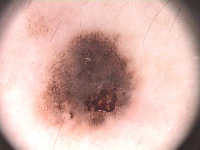</td><td>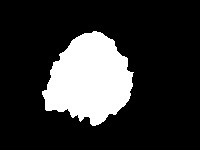</td></tr></table>

2. Разархивируем .rar файл.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем сегментировать их.

In [ ]:
!nvidia-smi

Fri Jun  5 08:58:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
! wget https://www.dropbox.com/s/4q6kwg8de56eqnc/PH2Dataset.rar

--2020-06-09 19:57:28--  https://www.dropbox.com/s/4q6kwg8de56eqnc/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/4q6kwg8de56eqnc/PH2Dataset.rar [following]
--2020-06-09 19:57:29--  https://www.dropbox.com/s/raw/4q6kwg8de56eqnc/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb13fd8d59babd7458b193eae2e.dl.dropboxusercontent.com/cd/0/inline/A5Ub3Lj4kZFPZaeVWwKhR5Xrti5fKdlbJtOZPOm_hQ90pLJevVL0F7oIGrgG22yVL1IaltWom8oaTJl3xgFQyuuLL76j2cCPvFSVb9AST7qxWLipX9BXFL0S0UsCfMsu1S0/file# [following]
--2020-06-09 19:57:31--  https://ucb13fd8d59babd7458b193eae2e.dl.dropboxusercontent.com/cd/0/inline/A5Ub3Lj4kZFPZaeVWwKhR5Xrti5fKdlbJtOZPOm_hQ90pLJevVL0F7oIGrgG22yVL1IaltWom8oaTJl3xgFQyuuLL76j2cCPvFSVb9AST

In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

Для загрузки датасета я предлагаю использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

In [ ]:
images[0].shape

(576, 767, 3)

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize) можно использовать для изменения размера изображений. 
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
X

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
X[0].shape

(256, 256, 3)

In [ ]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

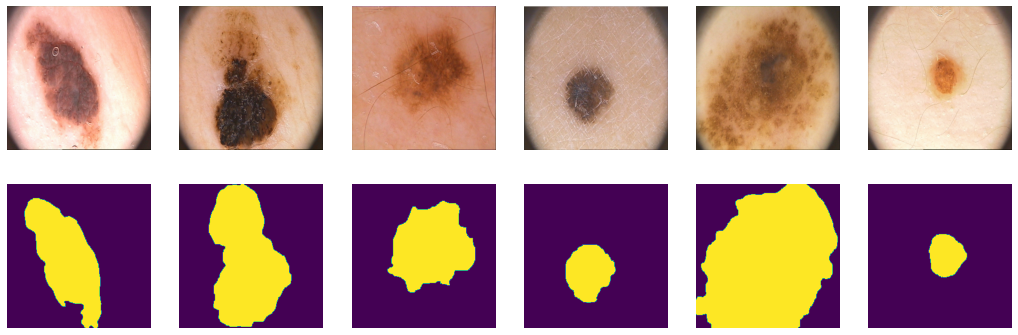

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для валидации и теста

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:



## SegNet 

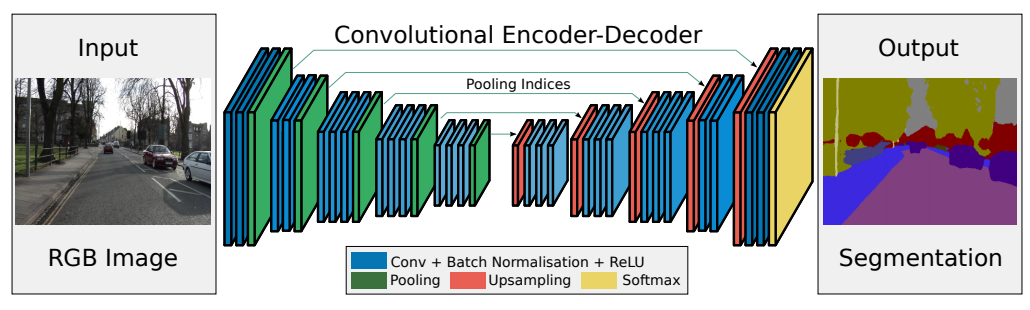

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


To clarify this we can see on the segmentation:
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


And the intersection will be the following:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  
    union = (outputs | labels).float().sum((1, 2))         
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  
    
    return thresholded

## функция лосса 

Теперь не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) в Тарая функция эквивалентна и не так подвержена численной неустойчивости.

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
def bce_loss(y_pred, y_real):
    y_pred = torch.sigmoid(y_pred) #Переведем предсказания в вероятности
    return (y_pred - y_real*y_pred + torch.log(1 + torch.exp(-y_pred))).mean()

## Тренировка

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [ ]:
# посмотрим размерности батчей c train выборки
X_val, Y_val = next(iter(data_val))
X_val.size()

torch.Size([25, 3, 256, 256])

In [ ]:
for X_batch, Y_batch in data_tr:
    # data to device
    X_batch, Y_batch
    break

X_batch.shape, Y_batch.shape

(torch.Size([25, 3, 256, 256]), torch.Size([25, 1, 256, 256]))

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val,data_ts, show_val=True):
    X_val, Y_val = next(iter(data_val))
    history = []
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        corr = 0
        processed_size=0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            loss =  loss_fn(Y_pred, Y_batch) # forward-pass
            loss.backward() # backward-pass
            opt.step() # update weights
            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
            corr += iou_pytorch(torch.sigmoid(model(X_batch.to(device)))>0.5, Y_batch.to(device)).mean().item()
            processed_size += X_batch.size(0)
        train_loss = avg_loss
        train_acc = corr/len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)

        # визуализируем получаемые на каждой эпохе результаты
        model.eval()  # testing mode 
        running_loss = 0.0
        running_corrects = 0
        processed_size = 0
        for inputs, labels in data_val: #Валидация
          inputs = inputs.to(DEVICE)
          labels = labels.to(DEVICE)
          with torch.set_grad_enabled(False):
            preds = model(inputs)
            loss = loss_fn(preds, labels)
          running_loss += loss.item() / len(data_val)
          running_corrects += iou_pytorch(torch.sigmoid(model(inputs))>0.5, labels).mean().item()
          processed_size += inputs.size(0)
        val_loss = running_loss 
        val_acc = running_corrects/len(data_val)

        model.eval()  # testing mode
        test_loss = 0.0
        test_running_corrects = 0
        for inputs_ts, labels_ts in data_ts: #Тест
          inputs_ts = inputs_ts.to(DEVICE)
          labels_ts = labels_ts.to(DEVICE)
          with torch.set_grad_enabled(False):
            preds = model(inputs_ts)
            loss = loss_fn(preds, labels_ts)
          test_loss += loss.item() / len(data_ts)
          test_running_corrects += iou_pytorch(torch.sigmoid(model(inputs_ts))>0.5, labels_ts).mean().item()
        ts_loss = test_loss 
        ts_acc = test_running_corrects/len(data_ts)

        if show_val:
            # предскажем маску на изображениях из val выборки
            Y_hat_val = torch.sigmoid(model(X_val.to(device))).cpu().detach().numpy()

        else:
            # выполним предсказания на изображениях из train выборки
            Y_hat_train = torch.sigmoid(Y_pred).cpu().detach().numpy()
            X_batch = X_batch.cpu().detach().numpy()
            Y_batch = Y_batch.cpu().detach().numpy()

        # визуализируем получаемые на каждой эпохе результаты
        clear_output(wait=True)

        if show_val:
            row_names = ['Картинка из val', 'Маска нейросети на картинке val',
                     'Реальная маска картинки из val выборки']
        else:
            row_names = ['Картинка из train', 'Маска нейросети на картинке train',
                     'Реальная маска картинки из train выборки']


        fig, big_axes = plt.subplots( figsize=(12, 8) , nrows=3, ncols=1, sharey=True) 
        for row, big_ax in enumerate(big_axes, start=1):
            big_ax.set_title(row_names[row-1], fontsize=16)

            
            big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
            
            big_ax._frameon = False

        for k in range(6):
            if show_val:
                ax = fig.add_subplot(3, 6, k+1)
                ax.imshow(X_val[k, 0], cmap='gray')
                plt.axis('off')
                fig.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))

                ax = fig.add_subplot(3, 6, k+7)
                plt.imshow(Y_hat_val[k, 0]>0.5, cmap='gray')
                plt.axis('off')

                ax = fig.add_subplot(3, 6, k+13)
                plt.imshow(Y_val[k, 0], cmap='gray')
                plt.axis('off')

            else:
                ax = fig.add_subplot(3, 6, k+1)
                ax.imshow(X_batch[k, 0], cmap='gray')
                plt.axis('off')
                fig.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))

                ax = fig.add_subplot(3, 6, k+7)
                plt.imshow(Y_hat_train[k, 0]>0.5, cmap='gray')
                plt.axis('off')

                ax = fig.add_subplot(3, 6, k+13)
                plt.imshow(Y_batch[k, 0], cmap='gray')
                plt.axis('off')

        fig.set_facecolor('w')
        plt.tight_layout()
        plt.show()
        history.append((train_loss, train_acc, val_loss, val_acc, ts_loss, ts_acc))
    return history

## Инференс

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    with torch.no_grad():
        Y_pred = [model(X_batch) for X_batch, _ in data]
    return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data):
    model.eval()  # включаем тест
    scores = 0

    with torch.no_grad():
        for X_batch, Y_label in data:
            # получаем вероятности принадлежности пикселей объекту
            Y_pred = torch.sigmoid(model(X_batch.to(device)))
            # Y_pred>0.5 получаем маску от нейросети по порогу в 0.5 вероятности
            scores += metric(Y_pred>0.5, Y_label.to(device)).mean().item()

    return scores/len(data)

In [ ]:


class SegNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(SegNet, self).__init__()

        
# encoder (downsampling)
        
        self.enc_conv0 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.norm0 = nn.BatchNorm2d(32)
        self.enc_conv0_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.norm1 = nn.BatchNorm2d(32)
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2)  # 256 -> 128
        
        self.enc_conv1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.norm2 = nn.BatchNorm2d(64)
        self.enc_conv1_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.norm3 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 128 -> 64
        
        self.enc_conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.norm5 = nn.BatchNorm2d(128)
        self.enc_conv2_1 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.norm6 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 64 -> 32

        self.enc_conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.norm7 = nn.BatchNorm2d(256)
        self.enc_conv3_1 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.norm8 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # bottleneck
        self.bottleneck_conv =  nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.norm9 = nn.BatchNorm2d(256)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2, mode='bilinear') # 16 -> 32
        self.dec_conv0 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.norm10 = nn.BatchNorm2d(128)
        self.dec_conv0_1 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.norm11 = nn.BatchNorm2d(128)
        
        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear')# 32 -> 64
        self.dec_conv1 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.norm12 = nn.BatchNorm2d(64)
        self.dec_conv1_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.norm13 = nn.BatchNorm2d(64)

        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear')# 32 -> 64
        self.dec_conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.norm14 = nn.BatchNorm2d(32)
        self.dec_conv2_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.norm15 = nn.BatchNorm2d(32)

        self.upsample3 = nn.Upsample(scale_factor=2, mode='bilinear')# 32 -> 64
        self.dec_conv3 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, padding=1)
        self.norm16 = nn.BatchNorm2d(1)
        
    def forward(self, x):
        x = self.norm0(F.relu(self.enc_conv0(x)))
        x = self.norm1(F.relu(self.enc_conv0_1(x)))
        x = self.pool0(x)
        
        x = self.norm2(F.relu(self.enc_conv1(x)))
        x = self.norm3(F.relu(self.enc_conv1_1(x)))
        x = self.pool1(x)
        
        x = self.norm5(F.relu(self.enc_conv2(x)))
        x = self.norm6(F.relu(self.enc_conv2_1(x)))
        x = self.pool2(x)

        x = self.norm7(F.relu(self.enc_conv3(x)))
        x = self.norm8(F.relu(self.enc_conv3_1(x)))
        x = self.pool3(x)

        # bottleneck
        x = self.norm9(self.bottleneck_conv(x))

        # decoder (upsampling)
        x = self.upsample0(x)
        x = self.norm10(F.relu(self.dec_conv0(x)))
        x = self.norm11(F.relu(self.dec_conv0_1(x)))
        
        x = self.upsample1(x)
        x = self.norm12(F.relu(self.dec_conv1(x)))
        x = self.norm13(F.relu(self.dec_conv1_1(x)))
        x = self.upsample2(x)
        x = self.norm14(F.relu(self.dec_conv2(x)))
        x = self.norm15(F.relu(self.dec_conv2_1(x)))

        x = self.upsample3(x)
        x =self.norm16(self.dec_conv3(x))
        return x

## Основной момент: обучение

##Segnet+BCELoss

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True #Будем фиксировать сиды перед каждым объявлением новой модели

In [ ]:
model = SegNet().to(device) #Объявляем модель

In [ ]:
DEVICE = 'cuda'

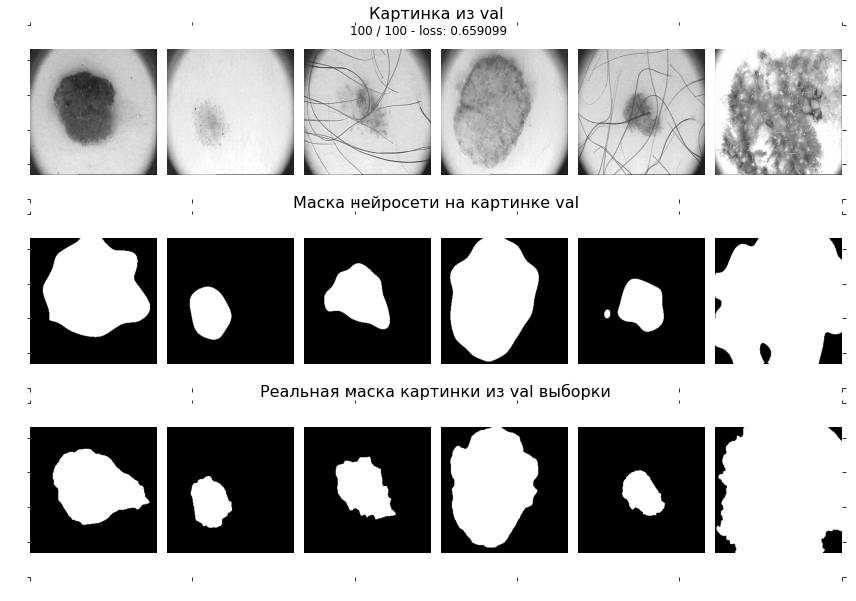

In [ ]:
max_epochs = 100
opt = optim.Adam(model.parameters())
history = train(model, opt, bce_loss, max_epochs, data_tr = data_tr, data_val = data_val, data_ts = data_ts, show_val=True) #Обучаем

In [ ]:
score_model(model, iou_pytorch, data_val) #Смотрим итоговый скор (метрика по перекрытию)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


0.7439999878406525

In [ ]:
loss, acc, val_loss, val_acc, ts_loss, ts_acc = zip(*history) 

Строим графики лосса и скора для контроля обучения и дальнейшего сравнения

In [ ]:
rcParams['axes.titlesize']=20

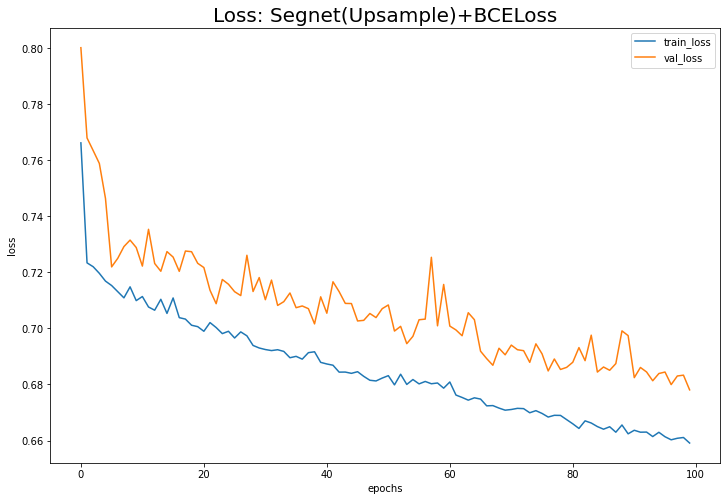

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.title('Loss: Segnet(Upsample)+BCELoss')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

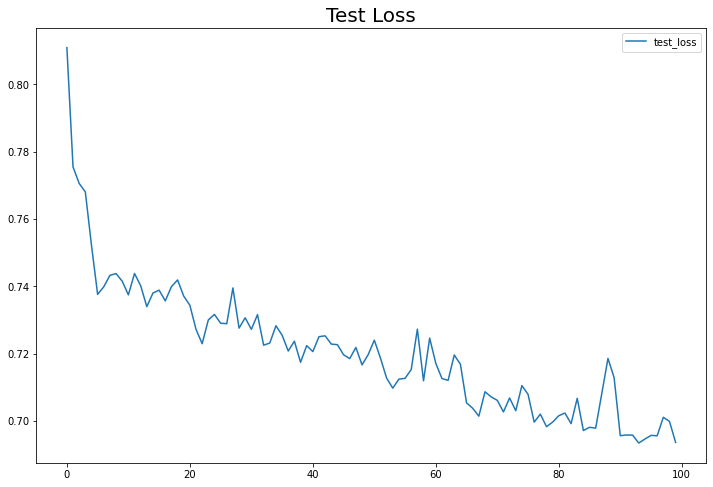

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('Test Loss')
plt.plot(ts_loss, label = 'test_loss')
plt.legend()

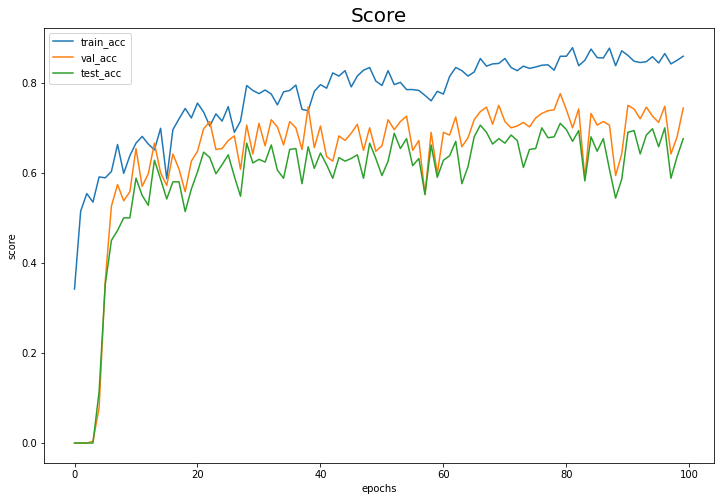

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.plot(ts_acc, label="test_acc")
plt.title('Score')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

-----------------------------------------------------------------------------------------

## Дополнительные функции лосса 

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

//  Не забудьте подумать о численной нестабильности.


In [ ]:
def dice_loss(y_pred, y_real, smooth=1e-08):
    y_pred = torch.sigmoid(y_pred)
    num = (2 * (y_real * y_pred)).sum()
    den = (y_real + y_pred).sum()
    res = 1 - (num / den) * (1 / (256 * 256))
    return res

In [ ]:
torch.cuda.empty_cache()

Проводим тестирование:

##SegNet+DiceLoss

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

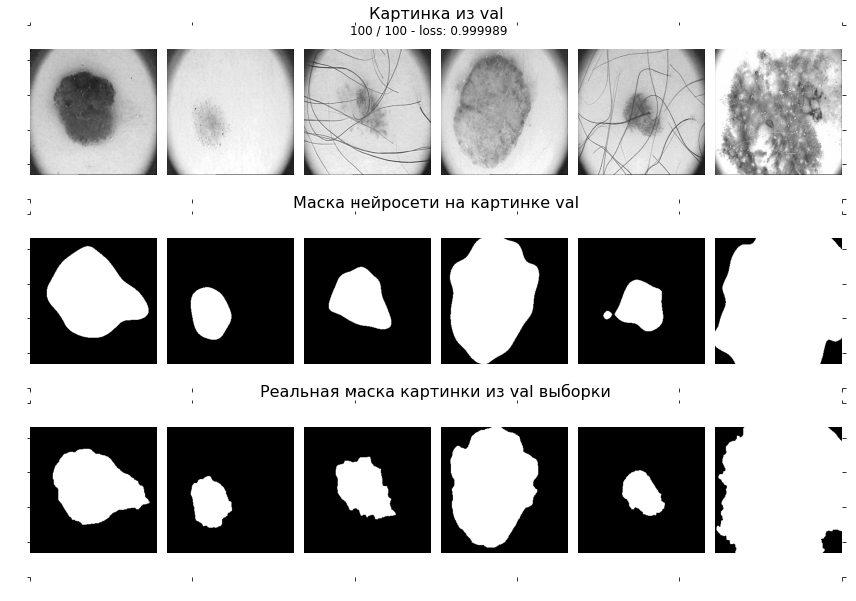

In [ ]:
model = SegNet().to(device)

max_epochs = 100
optimaizer = optim.Adam(model.parameters())
history = train(model, optimaizer, dice_loss, max_epochs, data_tr = data_tr, data_val = data_val, data_ts = data_ts)

In [ ]:
score_model(model, iou_pytorch, data_val)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


0.7659999430179596

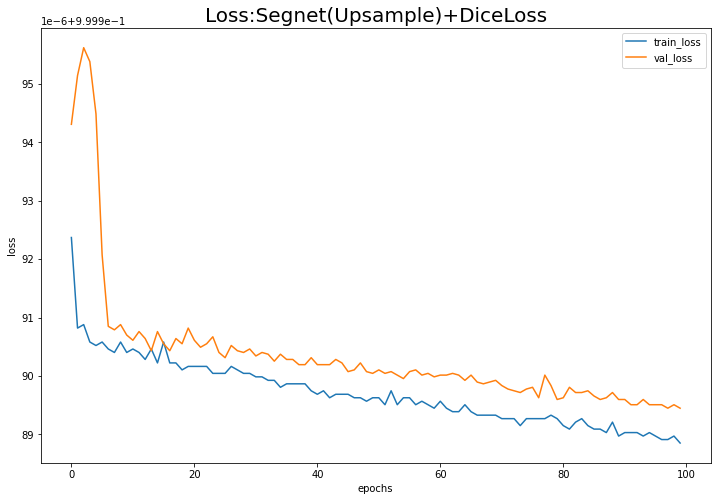

In [ ]:
loss, acc, val_loss, val_acc, ts_loss, ts_acc = zip(*history)
plt.figure(figsize=(12, 8))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.title('Loss:Segnet(Upsample)+DiceLoss')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

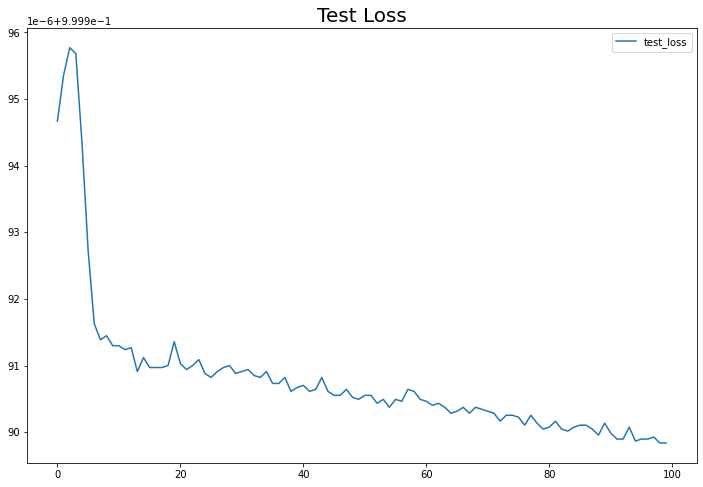

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('Test Loss')
plt.plot(ts_loss, label = 'test_loss')
plt.legend()

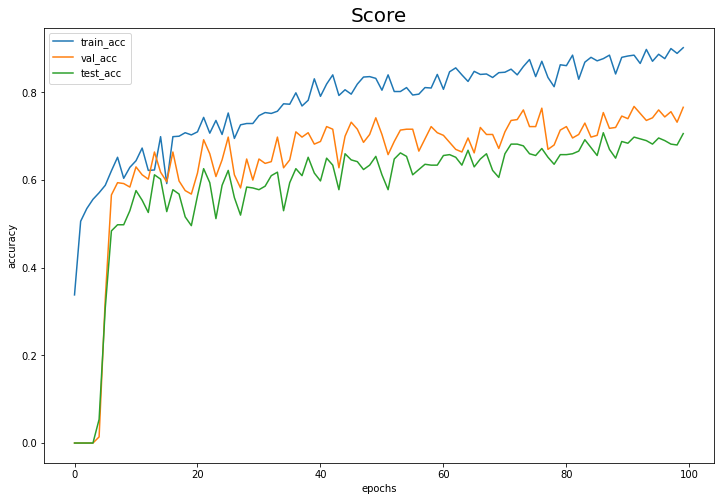

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.plot(ts_acc, label="test_acc")
plt.legend(loc='best')
plt.title('Score')
plt.xlabel("epochs")
plt.ylabel('accuracy')
plt.show()

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduce = reduce

    def forward(self, y_pred, y_real):
        y_pred = torch.sigmoid(y_pred) #Переведем предсказания в вероятности
        BCE = y_pred - y_real*y_pred + torch.log(1 + torch.exp(-y_pred))
        pt = torch.exp(-BCE)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE

        return torch.mean(F_loss)

In [ ]:
focal_loss = FocalLoss()

##SegNet+FocalLoss

In [ ]:
torch.cuda.empty_cache()

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

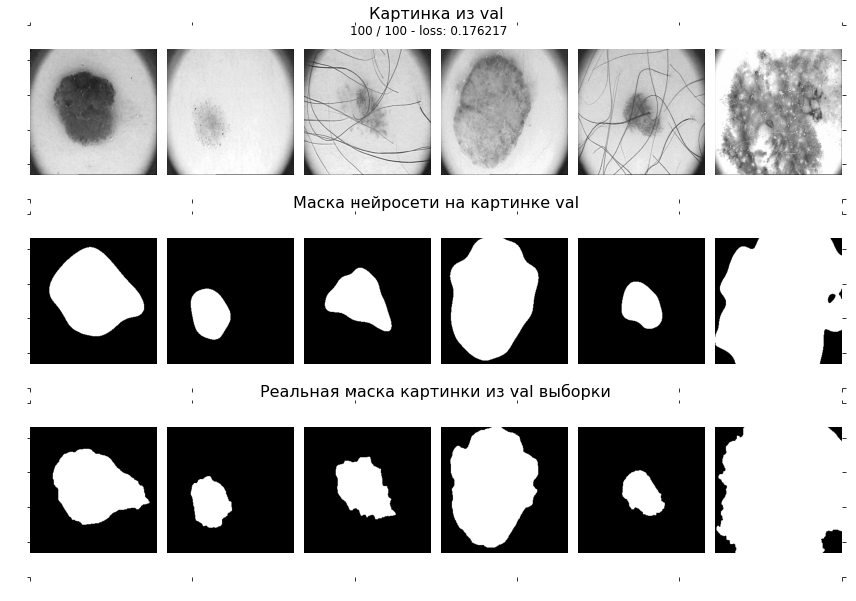

In [ ]:
model = SegNet().to(device)

max_epochs = 100
optimaizer = optim.Adam(model.parameters())
history=train(model, optimaizer, focal_loss, max_epochs, data_tr = data_tr, data_val = data_val, data_ts = data_ts)

In [ ]:
score_model(model, iou_pytorch, data_val)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


0.7479999661445618

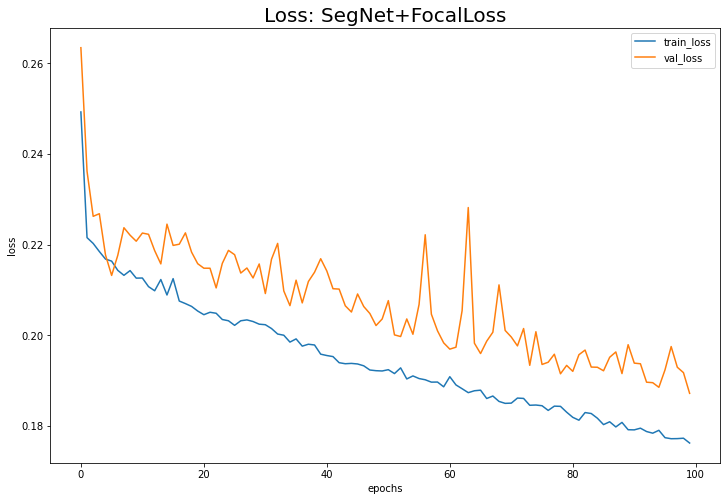

In [ ]:
loss, acc, val_loss, val_acc, ts_loss, ts_acc = zip(*history)
plt.figure(figsize=(12, 8))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.title('Loss: SegNet+FocalLoss')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

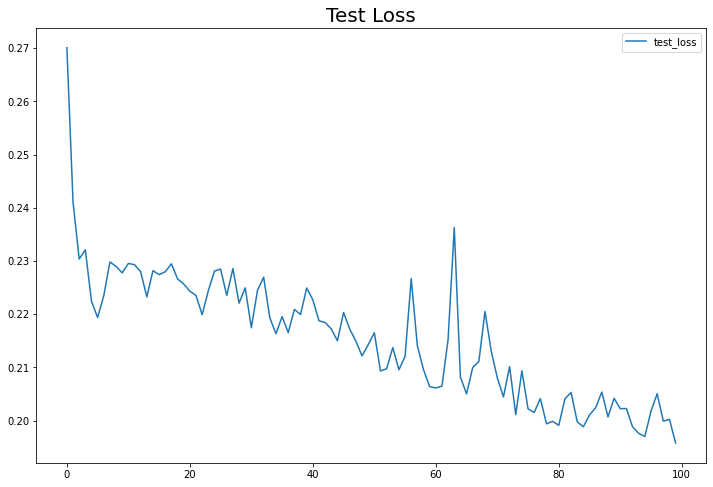

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('Test Loss')
plt.plot(ts_loss, label = 'test_loss')
plt.legend()

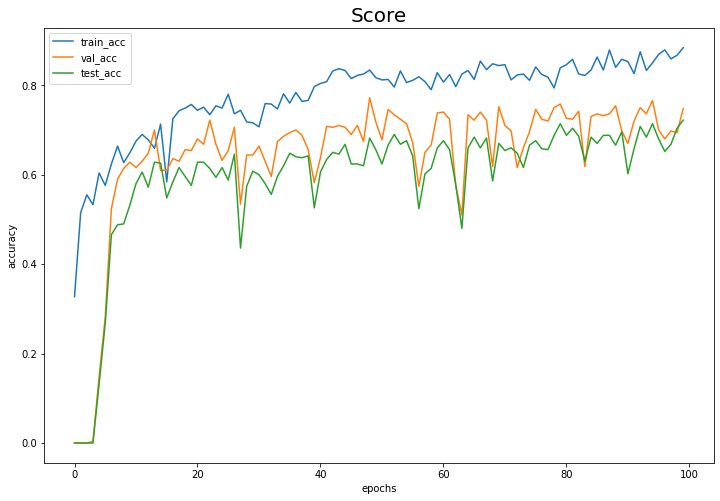

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.plot(ts_acc, label="test_acc")
plt.title('Score')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

----------------------------------------------------------------------------------------------

## Мир сегментационных лоссов


Статья, откуда взят лосс https://arxiv.org/pdf/1910.08711.pdf





##Segnet+Structural similarity index


In [ ]:
def ssim(x, y, sigma=1.5, L = 255, K1=0.01, K2=0.03):
    c1 = (K1*L)**2
    c2 = (K2*L)**2
    x = torch.sigmoid(x)
    cov = torch.mean((x-torch.mean(x))*(y - torch.mean(y)))
    ssim = (torch.std(x)**2+torch.std(y)**2-2*cov)/(torch.std(x)**2+torch.std(y)**2+c2)
    return ssim

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

In [ ]:
model = SegNet().to(device)

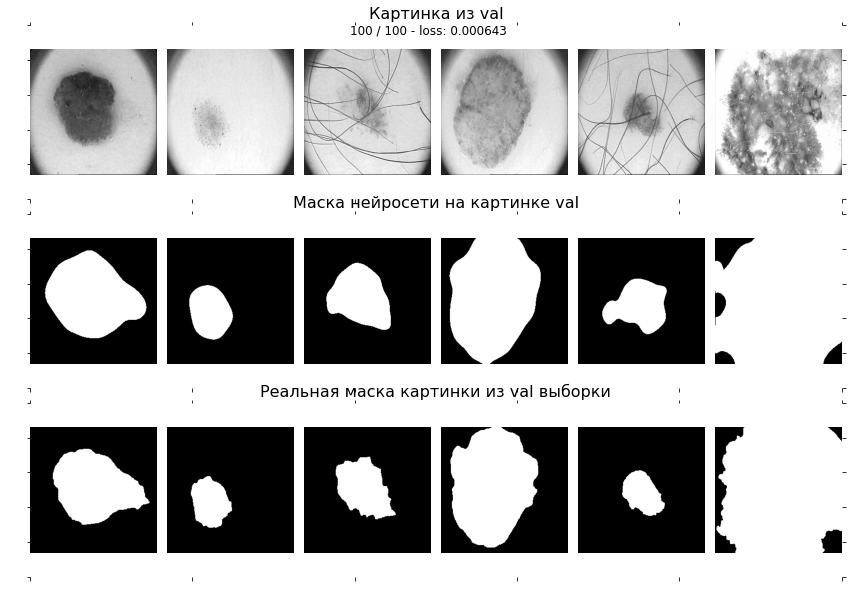

In [ ]:
max_epochs = 100
optimaizer = optim.Adam(model.parameters())
history=train(model, optimaizer, ssim, max_epochs, data_tr = data_tr, data_val = data_val, data_ts = data_ts)

In [ ]:
score_model(model, iou_pytorch, data_val)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


0.7240000069141388

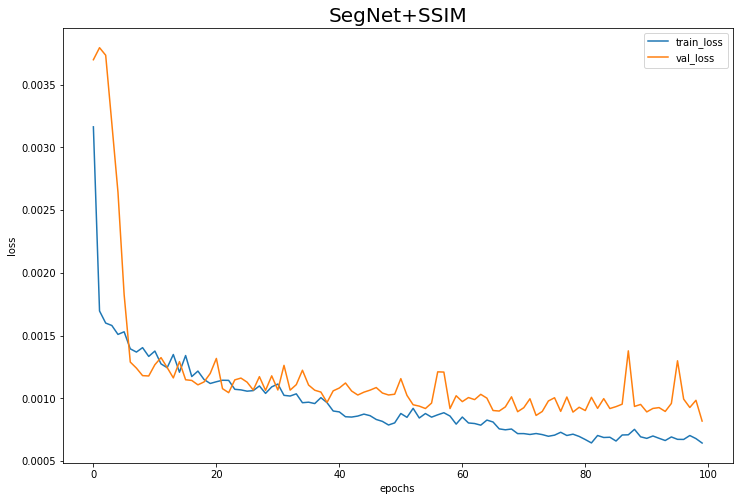

In [ ]:
loss, acc, val_loss, val_acc, ts_loss, ts_acc = zip(*history)
plt.figure(figsize=(12, 8))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.title('SegNet+SSIM')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

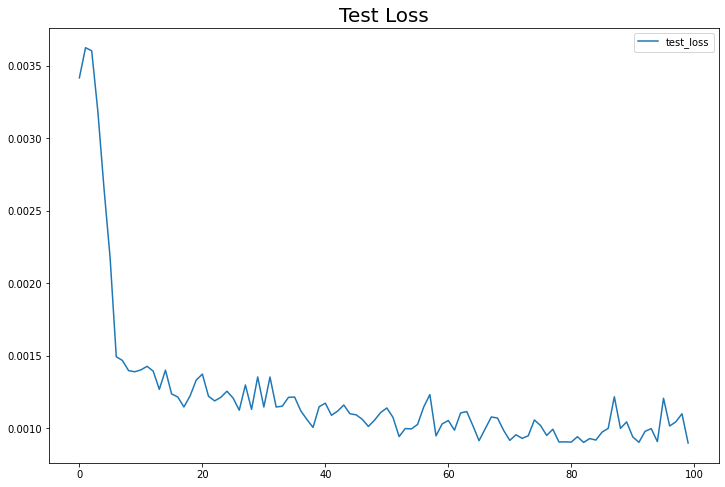

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('Test Loss')
plt.plot(ts_loss, label = 'test_loss')
plt.legend()

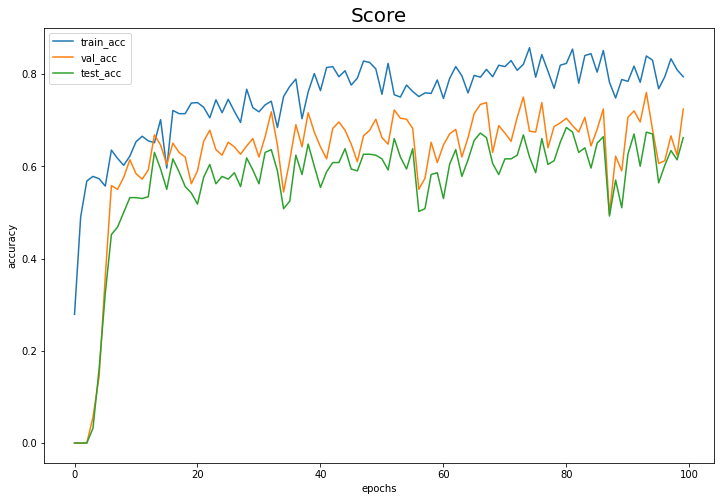

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.plot(ts_acc, label="test_acc")
plt.legend(loc='best')
plt.title('Score')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

##Заменим UpSample на MaxUnPool

In [ ]:
class SegNet2(nn.Module):
  def __init__(self):
        super().__init__()
        # encoder (downsampling)
        
        self.x0 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=2, dilation = 2),
                  nn.ReLU(),
                  nn.BatchNorm2d(32),
                  nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
                  nn.ReLU(),
                  nn.BatchNorm2d(32)) 
        self.pool0 = nn.MaxPool2d(2, stride = 2, return_indices=True)# 256 -> 128
        
        self.x1 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=4, dilation = 4),
                  nn.ReLU(),
                  nn.BatchNorm2d(64),
                  nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                  nn.ReLU(),
                  nn.BatchNorm2d(64))
        self.pool1 = nn.MaxPool2d(2, stride = 2,  return_indices=True)# 128 -> 64
        
        self.x2 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=8, dilation = 8),
                  nn.ReLU(),
                  nn.BatchNorm2d(128),
                  nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                  nn.ReLU(),
                  nn.BatchNorm2d(128))
        self.pool2 = nn.MaxPool2d(2, stride = 2,  return_indices=True)# 64 -> 32
        self.x3 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=16, dilation = 16),
                  nn.ReLU(),
                  nn.BatchNorm2d(256),
                  nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                  nn.ReLU(),
                  nn.BatchNorm2d(256))
        self.pool3 = nn.MaxPool2d(2, stride = 2,  return_indices=True)

        # decoder (upsampling)
        self.unpool0 = nn.MaxUnpool2d(2, stride = 2) # 16 -> 32
        self.y0 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=8, dilation = 8),
                  nn.ReLU(),
                  nn.BatchNorm2d(128),
                  nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                  nn.ReLU(),
                  nn.BatchNorm2d(128))
        
        self.unpool1 = nn.MaxUnpool2d(2, stride = 2)# 32 -> 64
        self.y1 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=4, dilation = 4),
                  nn.ReLU(),
                  nn.BatchNorm2d(64),
                  nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                  nn.ReLU(),
                  nn.BatchNorm2d(64))

        self.unpool2 = nn.MaxUnpool2d(2, stride = 2)# 32 -> 64
        self.y2 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=2, dilation = 2),
                  nn.ReLU(),
                  nn.BatchNorm2d(32),
                  nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
                  nn.ReLU(),
                  nn.BatchNorm2d(32))

        self.unpool3 = nn.MaxUnpool2d(2, stride = 2) # 32 -> 64
        self.y_final = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=2, dilation = 2),
                  nn.ReLU(),
                  nn.BatchNorm2d(32),
                  nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1),
                  nn.ReLU(),
                  nn.BatchNorm2d(16),
                  nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding=1))
        
  def forward(self, a):
    a = self.x0(a)
    a, indices0 = self.pool0(a)
    a = self.x1(a)
    a, indices1 = self.pool1(a)
    a = self.x2(a)
    a, indices2 = self.pool2(a)
    a = self.x3(a)
    a, indices3 = self.pool3(a)
    a = self.unpool0(a, indices3)
    a = self.y0(a)
    a = self.unpool1(a, indices2)
    a = self.y1(a)
    a = self.unpool2(a, indices1)
    a = self.y2(a)
    a = self.unpool2(a, indices0)
    a=self.y_final(a)
    return a

In [ ]:
torch.cuda.empty_cache()
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

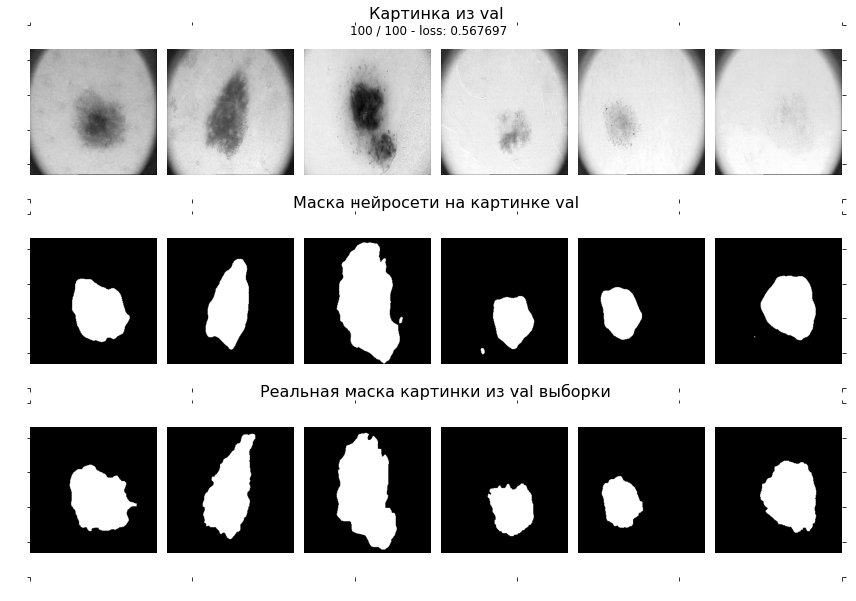

In [ ]:
model = SegNet2().to(device)
max_epochs = 100
optimaizer = optim.Adam(model.parameters())
history=train(model, optimaizer, bce_loss, max_epochs, data_tr = data_tr, data_val = data_val, data_ts = data_ts)

In [ ]:
score_model(model, iou_pytorch, data_val)

0.734000027179718

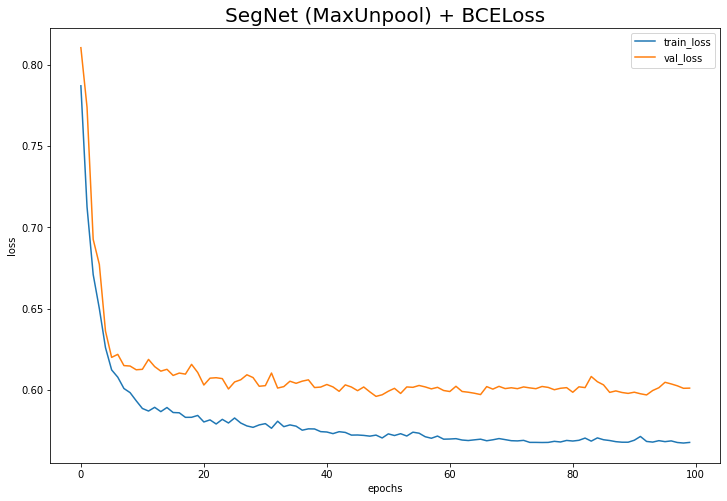

In [ ]:
loss, acc, val_loss, val_acc, ts_loss, ts_acc = zip(*history)
plt.figure(figsize=(12, 8))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.title('SegNet (MaxUnpool) + BCELoss')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

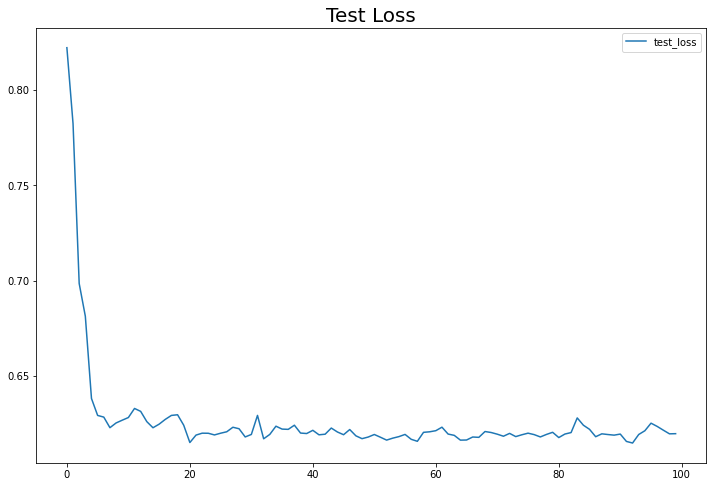

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('Test Loss')
plt.plot(ts_loss, label = 'test_loss')
plt.legend()

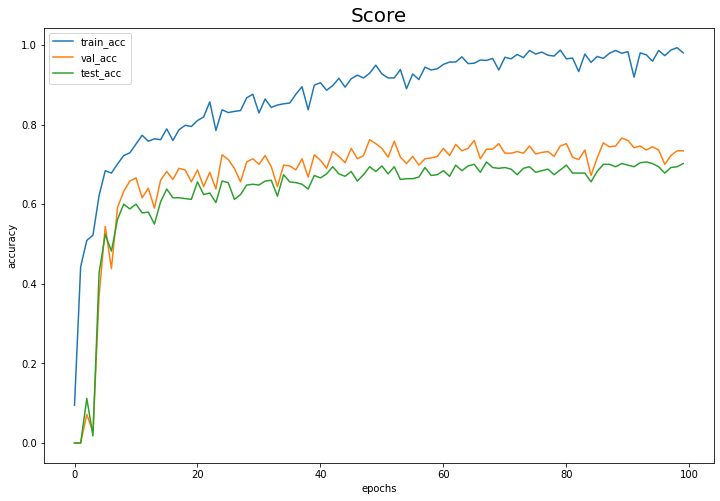

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.plot(ts_acc, label="test_acc")
plt.legend(loc='best')
plt.title('Score')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

In [ ]:
torch.cuda.empty_cache()
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

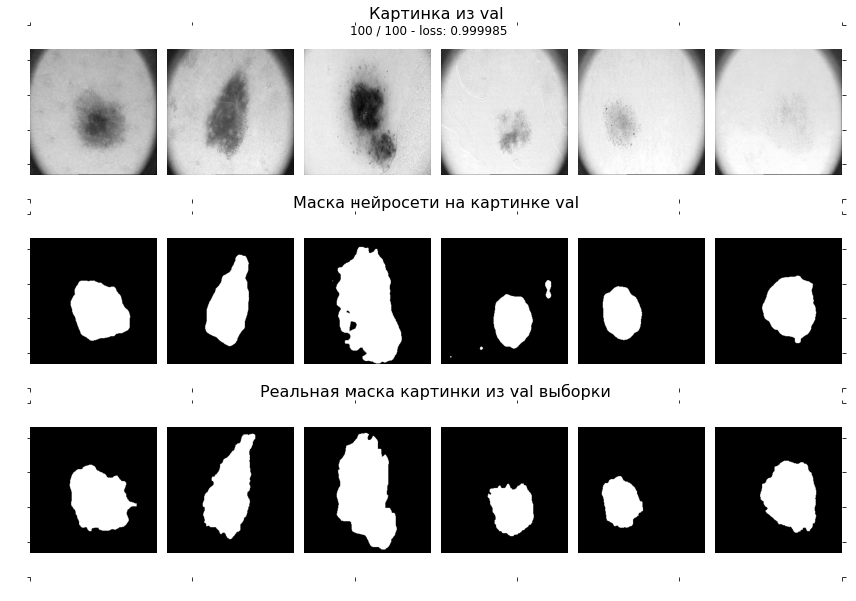

In [ ]:
model = SegNet2().to(device)
max_epochs = 100
optimaizer = optim.Adam(model.parameters())
history=train(model, optimaizer, dice_loss, max_epochs, data_tr = data_tr, data_val = data_val, data_ts = data_ts)

In [ ]:
score_model(model, iou_pytorch, data_val)

0.6720000207424164

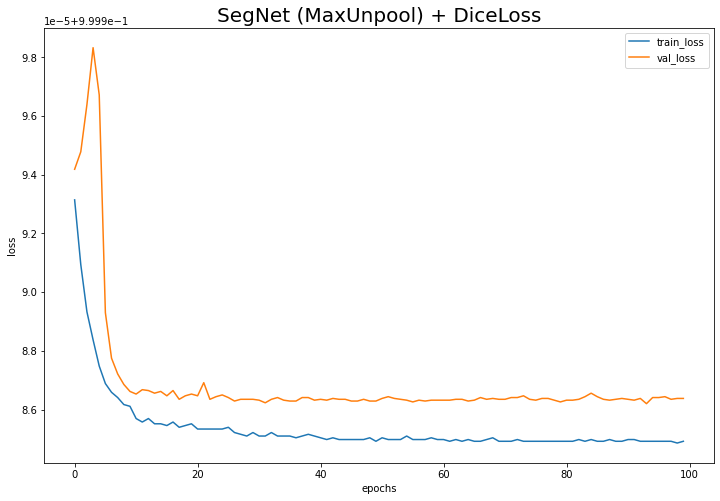

In [ ]:
loss, acc, val_loss, val_acc, ts_loss, ts_acc = zip(*history)
plt.figure(figsize=(12, 8))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.title('SegNet (MaxUnpool) + DiceLoss')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

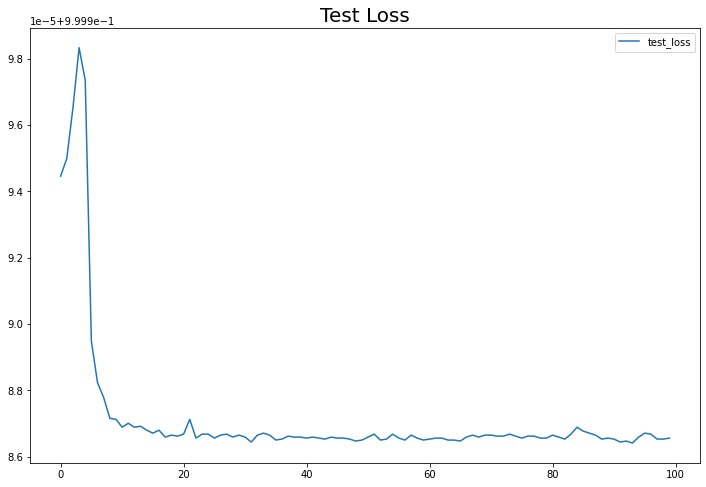

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('Test Loss')
plt.plot(ts_loss, label = 'test_loss')
plt.legend()

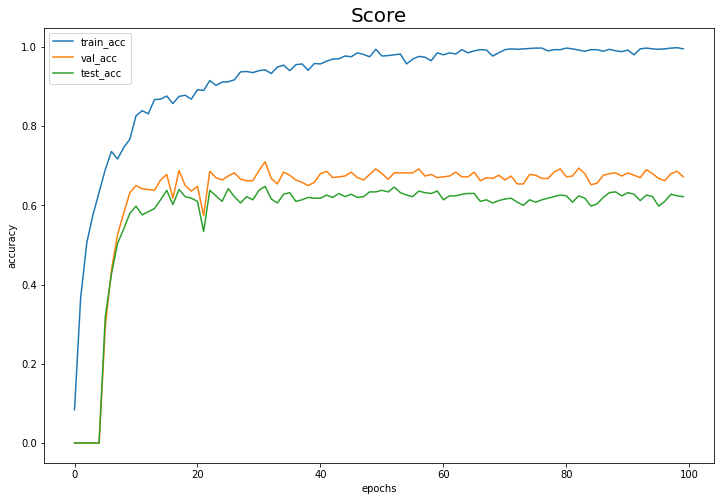

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.plot(ts_acc, label="test_acc")
plt.legend(loc='best')
plt.title('Score')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

In [ ]:
torch.cuda.empty_cache()
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

In [ ]:
DEVICE = 'cuda'

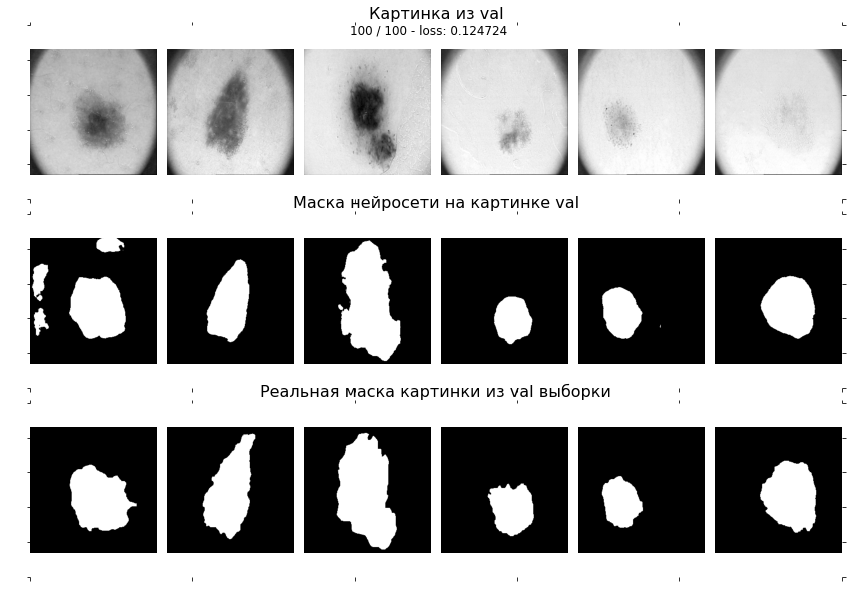

In [ ]:
model = SegNet2().to(device)
max_epochs = 100
optimaizer = optim.Adam(model.parameters())
history=train(model, optimaizer, focal_loss, max_epochs, data_tr = data_tr, data_val = data_val, data_ts = data_ts)

In [ ]:
score_model(model, iou_pytorch, data_val)

0.7019999921321869

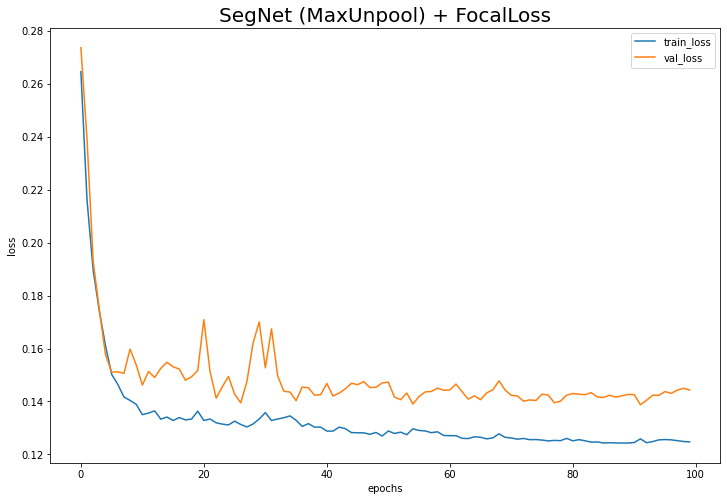

In [ ]:
loss, acc, val_loss, val_acc, ts_loss, ts_acc = zip(*history)
plt.figure(figsize=(12, 8))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.title('SegNet (MaxUnpool) + FocalLoss')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

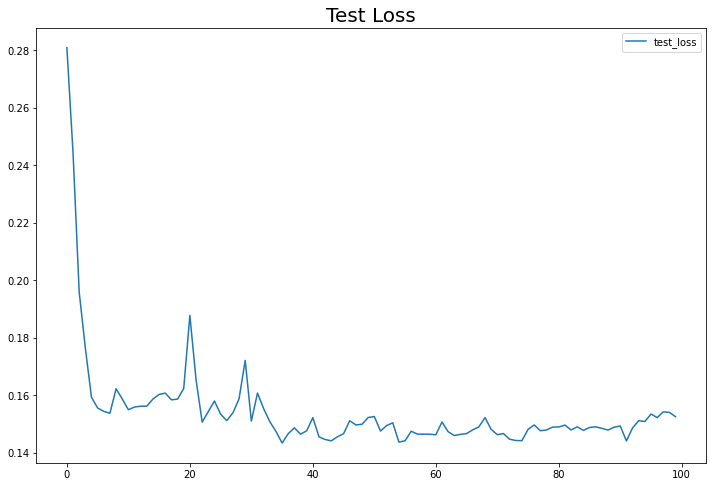

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('Test Loss')
plt.plot(ts_loss, label = 'test_loss')
plt.legend()

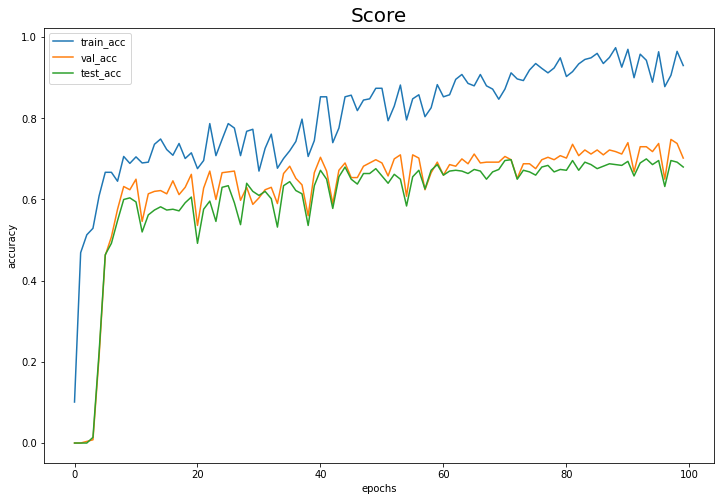

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.plot(ts_acc, label="test_acc")
plt.legend(loc='best')
plt.title('Score')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

In [ ]:
torch.cuda.empty_cache()
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

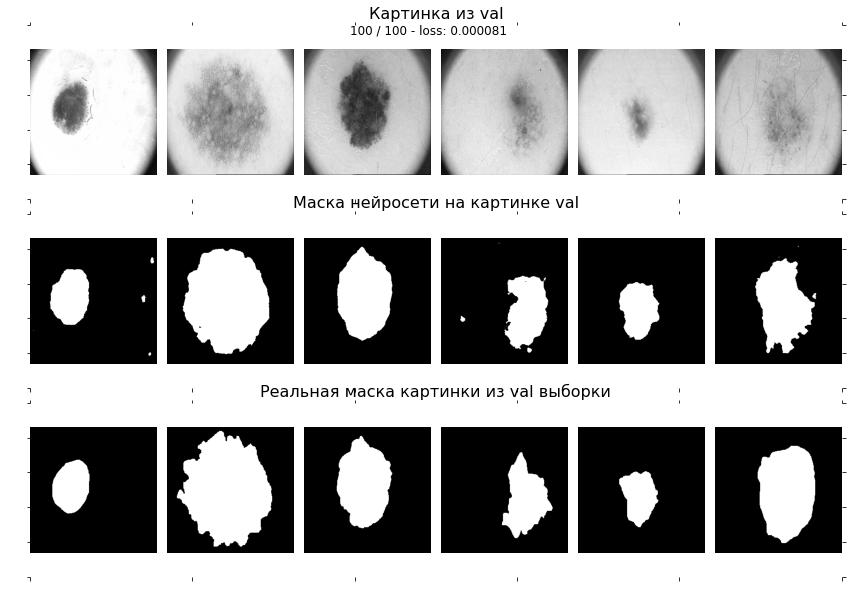

In [ ]:
model = SegNet2().to(device)
max_epochs = 100
optimaizer = optim.Adam(model.parameters())
history=train(model, optimaizer, ssim, max_epochs, data_tr = data_tr, data_val = data_val, data_ts = data_ts)

In [ ]:
score_model(model, iou_pytorch, data_val)

0.679999977350235

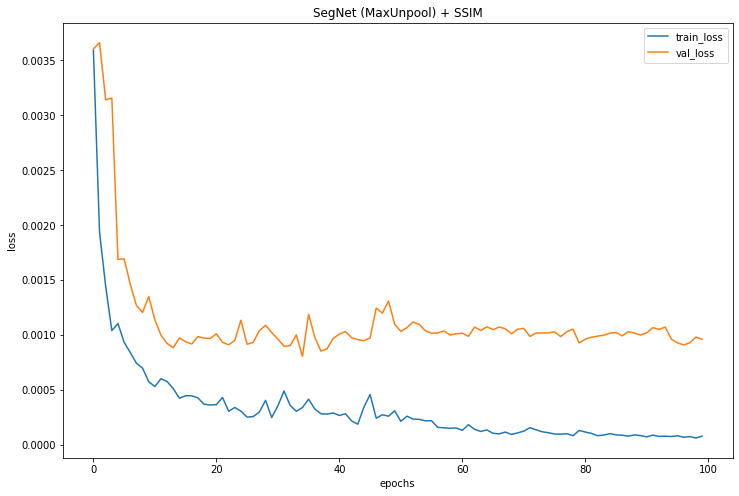

In [ ]:
loss, acc, val_loss, val_acc, ts_loss, ts_acc = zip(*history)
plt.figure(figsize=(12, 8))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.title('SegNet (MaxUnpool) + SSIM')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

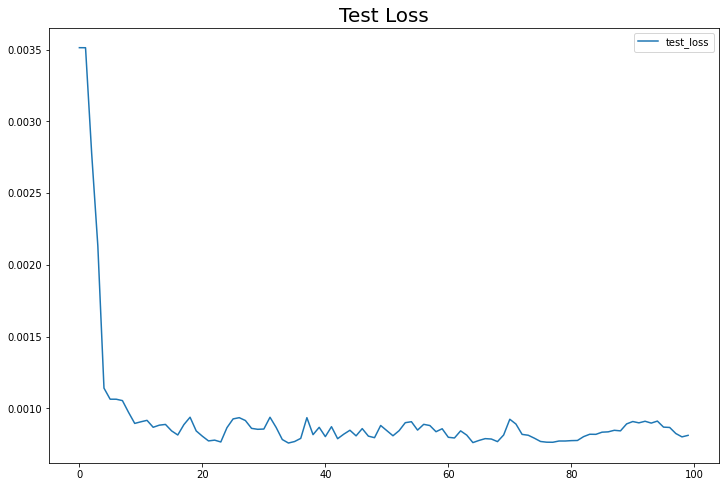

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('Test Loss')
plt.plot(ts_loss, label = 'test_loss')
plt.legend()

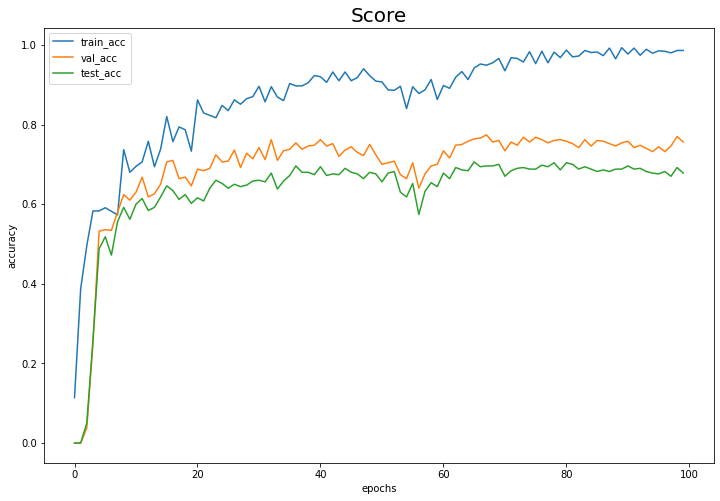

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.plot(ts_acc, label="test_acc")
plt.legend(loc='best')
plt.title('Score')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

-----------------------------------------------------------------------------------------

# U-Net

[**U-Net**](https://arxiv.org/abs/1505.04597) это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Учитывая медицинское изображение, он выводит изображение в оттенках серого, представляющее вероятность того, что каждый пиксель является интересующей областью.

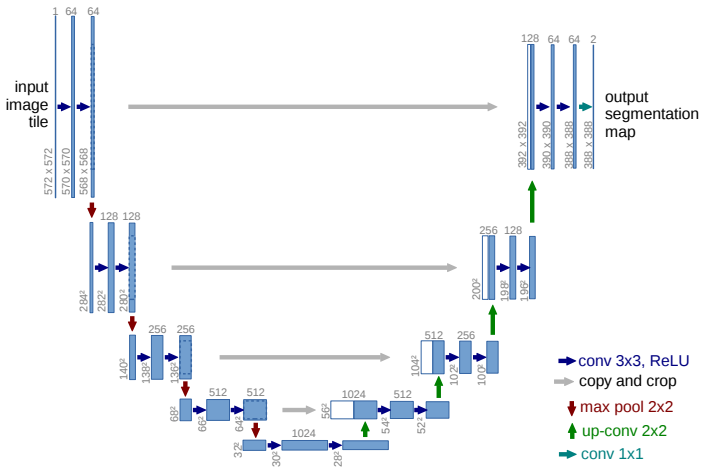

У нас в архитектуре все так же существует енкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются skip-conenctions. Элементы соединяющие части декодера и енкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
class UNet(nn.Module):
  def __init__(self):
        super().__init__()
        # encoder (downsampling)
        
        self.layer0= nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(32),
                                   nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(32))
        self.pool0 = nn.MaxPool2d(2, stride = 2)  # 256 -> 128
        
        self.layer1= nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(64),
                                   nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(64))
        self.pool1 = nn.MaxPool2d(2, stride = 2) # 128 -> 64
        
        self.layer2 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(128),
                                    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(128),
                                    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(128),)
        self.pool2 = nn.MaxPool2d(2, stride = 2) # 64 -> 32

        self.layer3 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(256),
                                    nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(256),
                                    nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(256))
        self.pool3 = nn.MaxPool2d(2, stride = 2)

        # bottleneck
        self.bottleneck =  nn.Sequential(nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(256))

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(256),
                                       nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(256),
                                       nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(256))
        
        self.upsample1 = nn.Upsample(scale_factor=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(nn.Conv2d(in_channels=384, out_channels=128, kernel_size=3, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(128),
                                       nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(128),
                                       nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(128))

        self.upsample2 = nn.Upsample(scale_factor=2)# 32 -> 64
        self.dec_conv2 = nn.Sequential(nn.Conv2d(in_channels=192, out_channels=64, kernel_size=3, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(64),
                                       nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(64))

        self.upsample3 = nn.Upsample(scale_factor=2)# 32 -> 64
        self.dec_conv3 = nn.Sequential(nn.Conv2d(in_channels=96, out_channels=64, kernel_size=3, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(64),
                                       nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(64),
                                       nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1))
        
  def forward(self, x):
        x = self.layer0(x)
        conv1 = torch.clone(x)
        x = self.pool0(x)
        
        x = self.layer1(x)
        conv2 = torch.clone(x)
        x = self.pool1(x)
        
        x = self.layer2(x)
        conv3 = torch.clone(x)
        x = self.pool2(x)

        x = self.layer3(x)
        conv4 = torch.clone(x)
        x = self.pool3(x)

        # bottleneck
        x = self.bottleneck(x)

        # decoder (upsampling)
        x = torch.cat((self.upsample0(x), conv4),1)
        x = self.dec_conv0(x)
        
        x = torch.cat((self.upsample1(x), conv3),1)
        x = self.dec_conv1(x)

        x = torch.cat((self.upsample2(x), conv2),1)
        x = self.dec_conv2(x)

        x =torch.cat((self.upsample3(x), conv1),1)
        x =self.dec_conv3(x)
        return x

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

In [ ]:
model = UNet().to(device)

In [ ]:
torch.cuda.empty_cache()
DEVICE='cuda'

##UNet+BCELoss

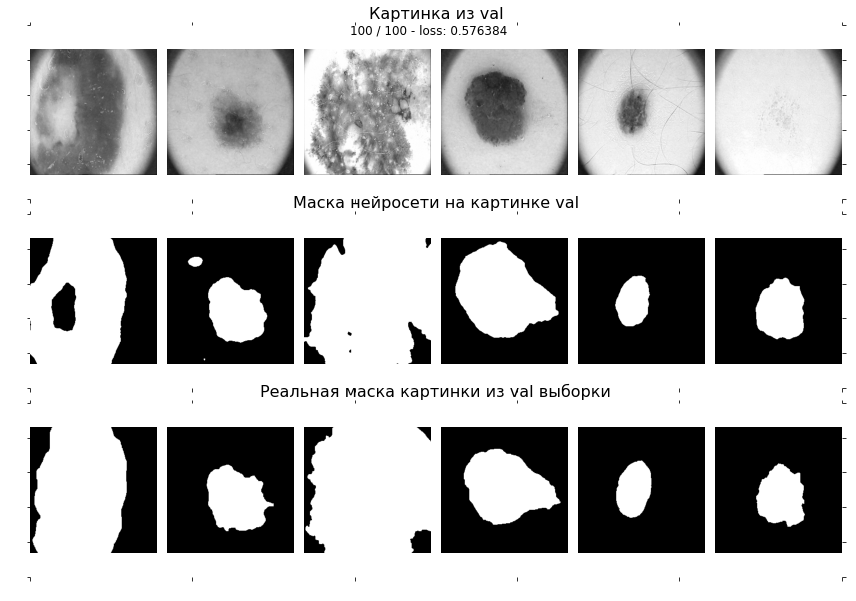

In [ ]:
history=train(model, torch.optim.Adam(model.parameters()), bce_loss, 100, data_tr = data_tr, data_val = data_val, data_ts = data_ts)

In [ ]:
score_model(model, iou_pytorch, data_val)

0.7579999566078186

In [ ]:
loss, acc, val_loss, val_acc, ts_loss, ts_acc = zip(*history)

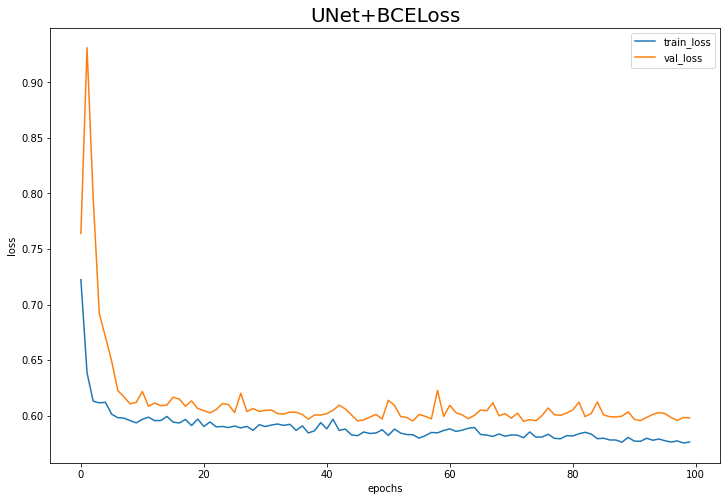

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.title('UNet+BCELoss')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

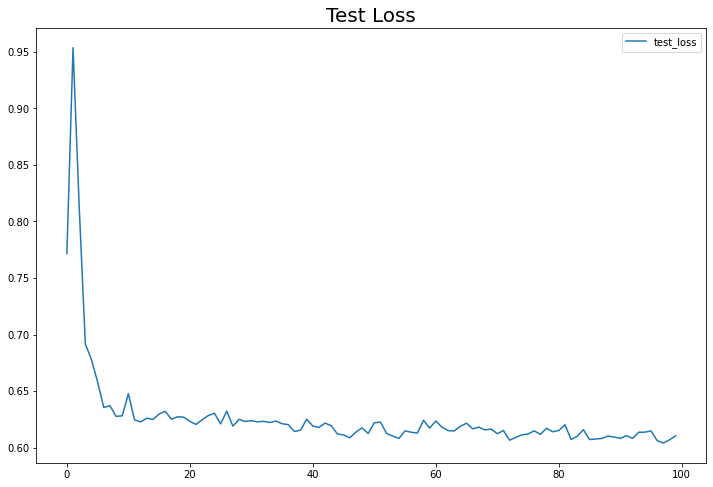

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('Test Loss')
plt.plot(ts_loss, label = 'test_loss')
plt.legend()

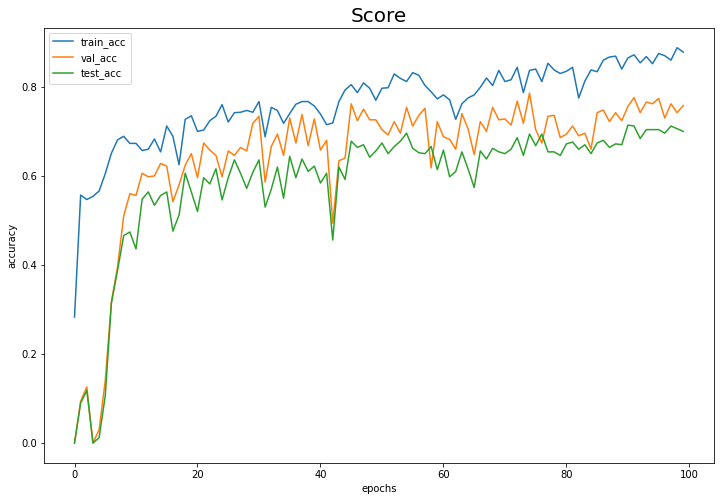

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.plot(ts_acc, label="test_acc")
plt.title('Score')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

##UNet+FocalLoss

In [ ]:
torch.cuda.empty_cache()

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

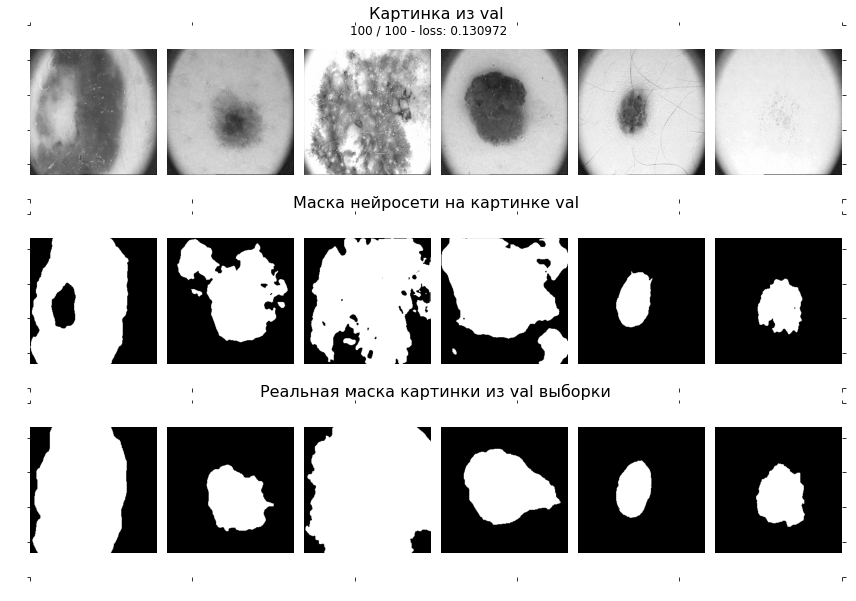

In [ ]:
model = UNet().to(device)
history=train(model, torch.optim.Adam(model.parameters()), focal_loss, 100, data_tr = data_tr, data_val = data_val, data_ts = data_ts)

In [ ]:
score_model(model, iou_pytorch, data_val)

0.6760000288486481

In [ ]:
loss, acc, val_loss, val_acc, ts_loss, ts_acc = zip(*history)

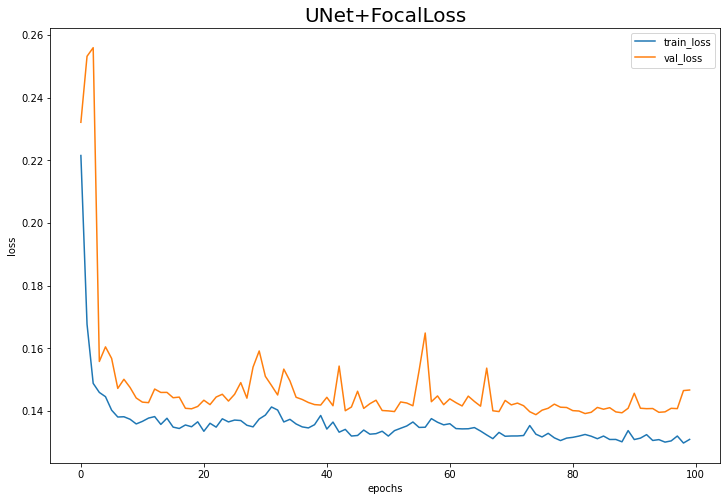

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.title('UNet+FocalLoss')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

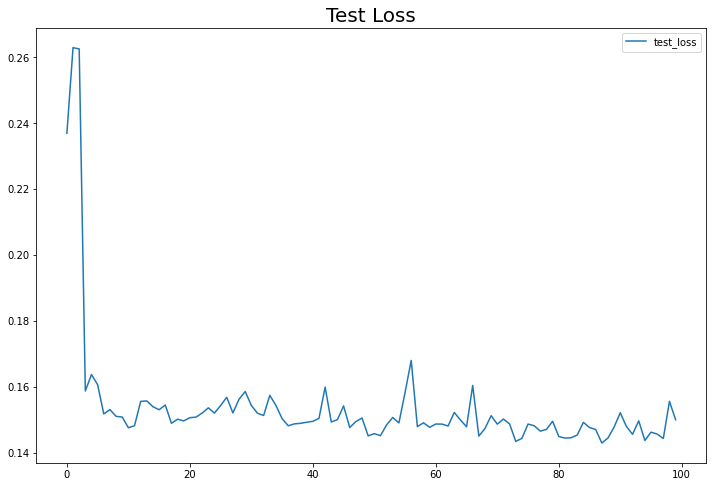

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('Test Loss')
plt.plot(ts_loss, label = 'test_loss')
plt.legend()

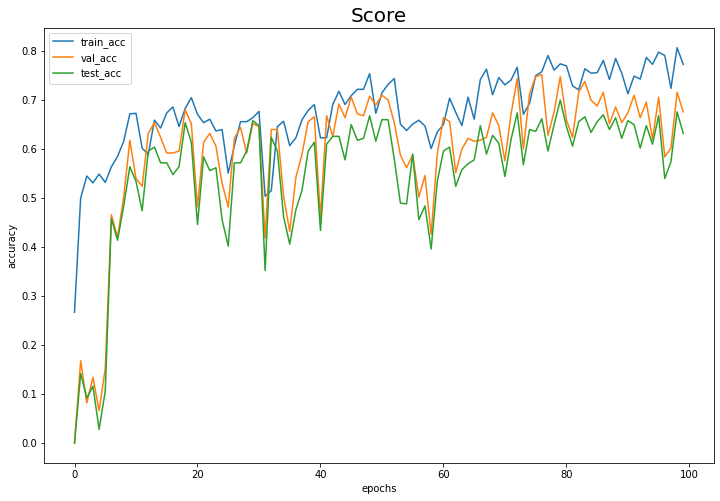

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.plot(ts_acc, label="test_acc")
plt.title('Score')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

In [ ]:
torch.cuda.empty_cache()
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

##UNet+DiceLoss

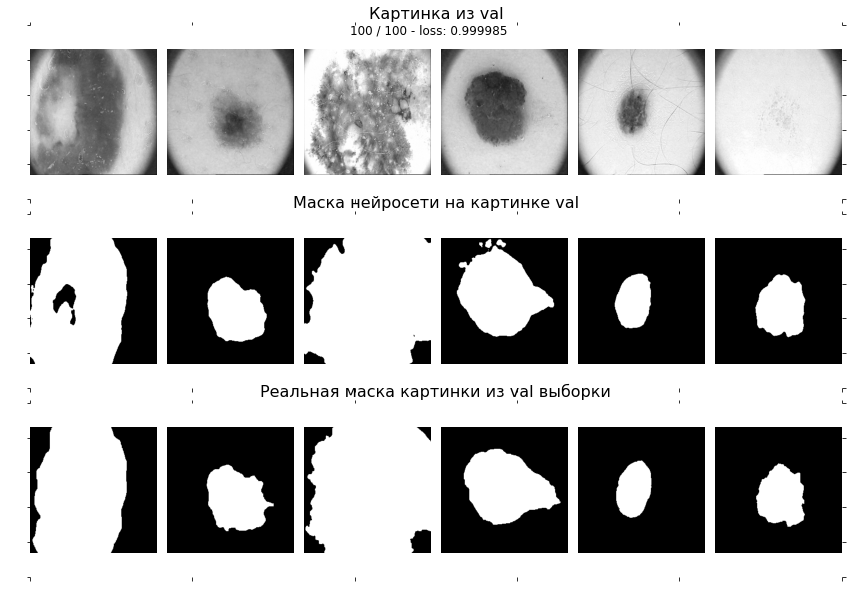

In [ ]:
model = UNet().to(device)

max_epochs = 100
optimaizer = optim.Adam(model.parameters())
history=train(model, optimaizer, dice_loss, max_epochs, data_tr = data_tr, data_val = data_val, data_ts = data_ts)

In [ ]:
score_model(model, iou_pytorch, data_val)

0.8120000064373016

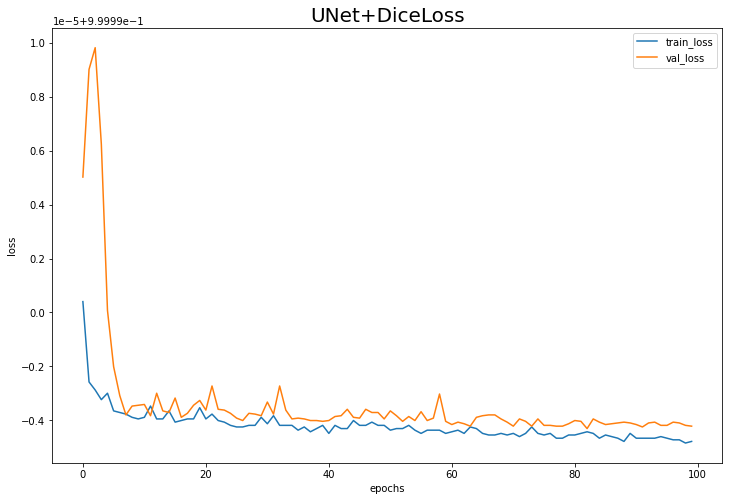

In [ ]:
loss, acc, val_loss, val_acc, ts_loss, ts_acc = zip(*history)
plt.figure(figsize=(12, 8))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.title('UNet+DiceLoss')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

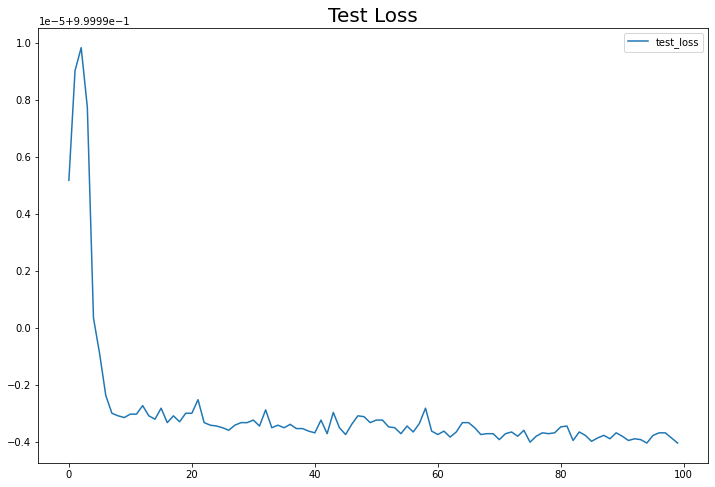

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('Test Loss')
plt.plot(ts_loss, label = 'test_loss')
plt.legend()

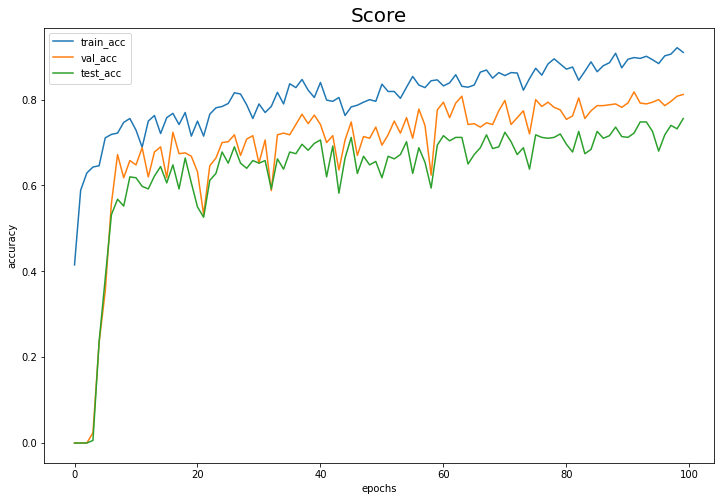

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.plot(ts_acc, label="test_acc")
plt.title('Score')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

##UNet+SSIM

In [ ]:
torch.cuda.empty_cache()
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

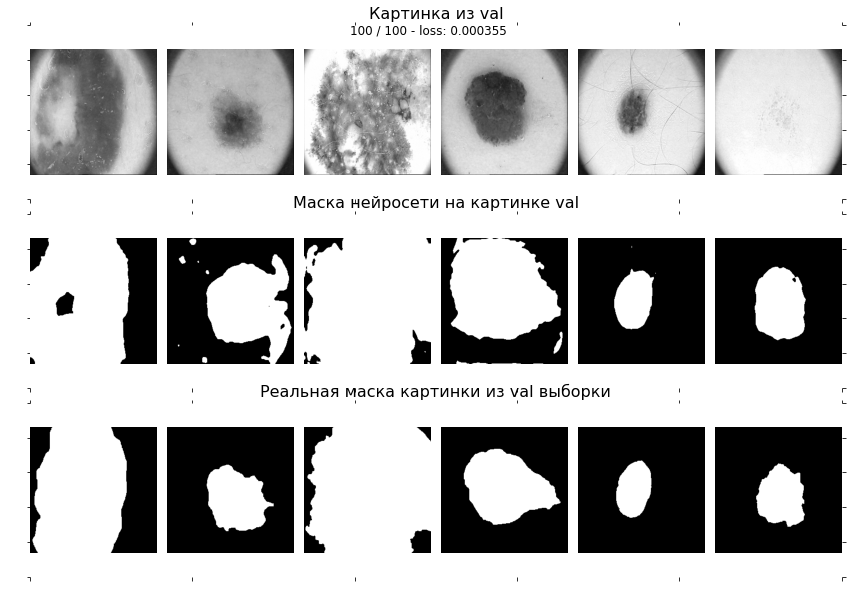

In [ ]:
model = UNet().to(device)

max_epochs = 100
optimaizer = optim.Adam(model.parameters())
history=train(model, optimaizer, ssim, max_epochs, data_tr = data_tr, data_val = data_val, data_ts = data_ts)

In [ ]:
score_model(model, iou_pytorch, data_val)

0.6899999976158142

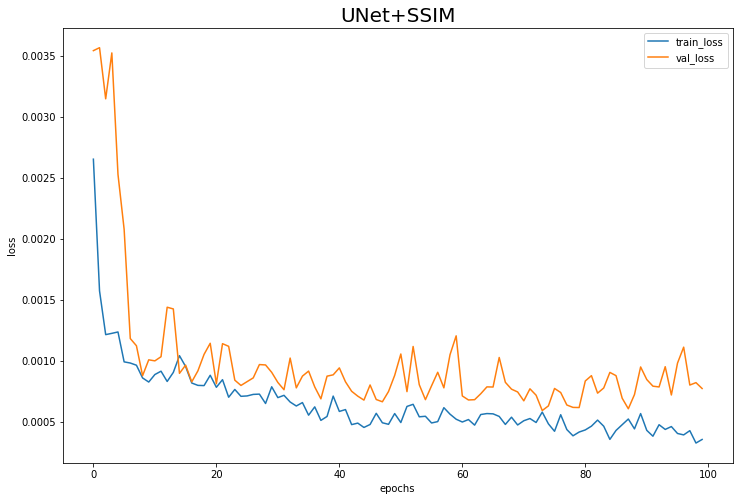

In [ ]:
loss, acc, val_loss, val_acc, ts_loss, ts_acc = zip(*history)
plt.figure(figsize=(12, 8))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.title('UNet+SSIM')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

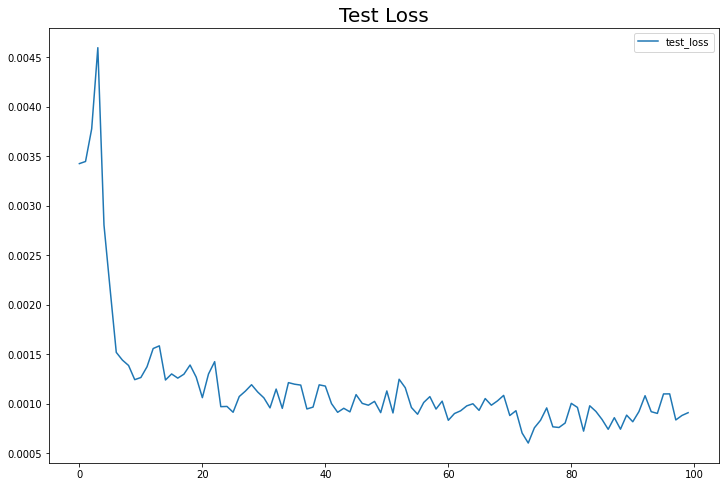

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('Test Loss')
plt.plot(ts_loss, label = 'test_loss')
plt.legend()

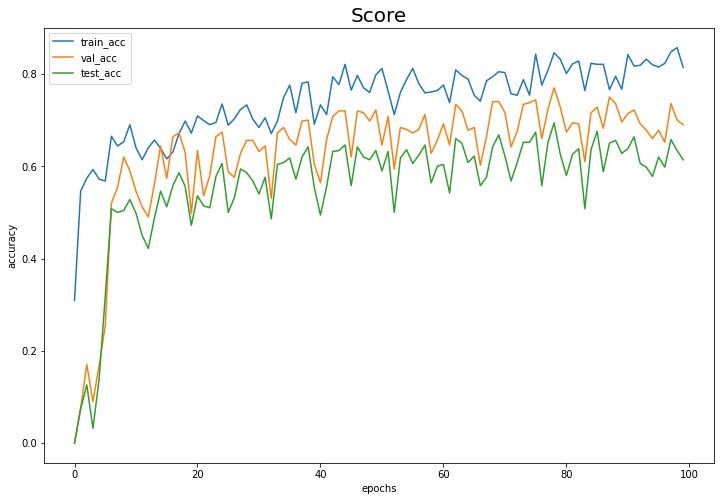

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.plot(ts_acc, label="test_acc")
plt.title('Score')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [ ]:
class UNet2(nn.Module):
  def __init__(self):
        super().__init__()
        # encoder (downsampling)
        
        self.layer0= nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(32),
                                   nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(32))
        self.pool0 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1, stride = 2)  # 256 -> 128
        
        self.layer1= nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(64),
                                   nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(64))
        self.pool1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride = 2) # 128 -> 64
        
        self.layer2 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(128),
                                    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(128),
                                    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(128),)
        self.pool2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride = 2) # 64 -> 32

        self.layer3 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(256),
                                    nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(256),
                                    nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(256))
        self.pool3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride = 2, padding=1)

        # bottleneck
        self.bottleneck =  nn.Sequential(nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(256))

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(in_channels = 256, out_channels = 256, kernel_size =3, stride = 2, output_padding = 1, padding=1) # 16 -> 32
        self.dec_conv0 = nn.Sequential(nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(256),
                                       nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(256),
                                       nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(256))
        
        self.upsample1 = nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size =3, stride = 2, output_padding = 1, padding=1)# 32 -> 64
        self.dec_conv1 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(128),
                                       nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(128),
                                       nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(128))

        self.upsample2 = nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size =3, stride = 2,output_padding = 1, padding=1)# 32 -> 64
        self.dec_conv2 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(64),
                                       nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(64))

        self.upsample3 = nn.ConvTranspose2d(in_channels = 64, out_channels = 32, kernel_size =3, stride = 2,output_padding = 1, padding=1)# 32 -> 64
        self.dec_conv3 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(32),
                                       nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(32),
                                       nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, padding=1))
        
  def forward(self, x):
        x = self.layer0(x)
        conv1 = torch.clone(x)
        x = self.pool0(x)
        
        x = self.layer1(x)
        conv2 = torch.clone(x)
        x = self.pool1(x)
        
        x = self.layer2(x)
        conv3 = torch.clone(x)
        x = self.pool2(x)

        x = self.layer3(x)
        conv4 = torch.clone(x)
        x = self.pool3(x)

        # bottleneck
        x = self.bottleneck(x)

        # decoder (upsampling)
        x = torch.cat((self.upsample0(x), conv4),1)
        x = self.dec_conv0(x)
        
        x = torch.cat((self.upsample1(x), conv3),1)
        x = self.dec_conv1(x)

        x = torch.cat((self.upsample2(x), conv2),1)
        x = self.dec_conv2(x)

        x =torch.cat((self.upsample3(x), conv1),1)
        x =self.dec_conv3(x)
        return x


##Unet2+BCELoss

In [ ]:
torch.cuda.empty_cache()
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

In [ ]:
model = UNet2().to(device)


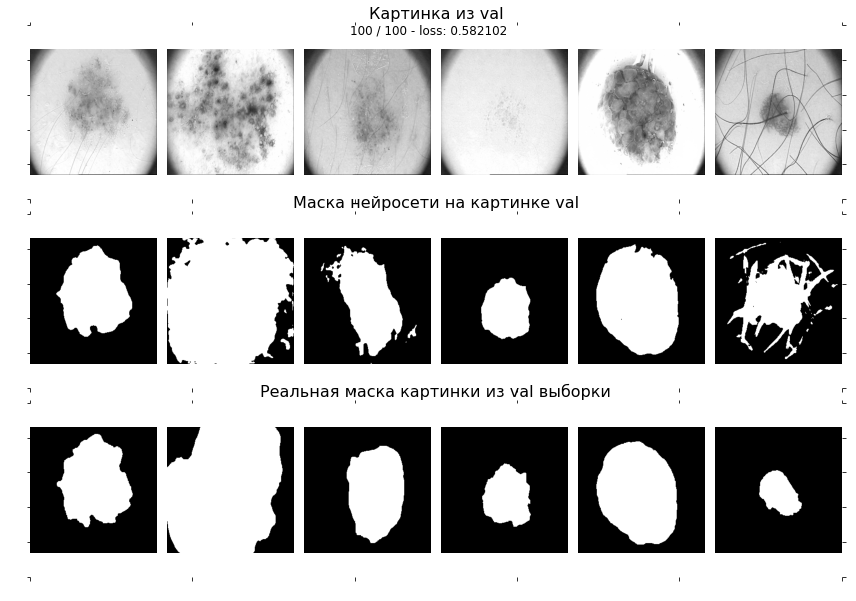

In [ ]:
history = train(model, optim.Adam(model.parameters()), bce_loss, 100, data_tr = data_tr, data_val = data_val, data_ts = data_ts)

In [ ]:
score_model(model, iou_pytorch, data_val)

0.7239999771118164

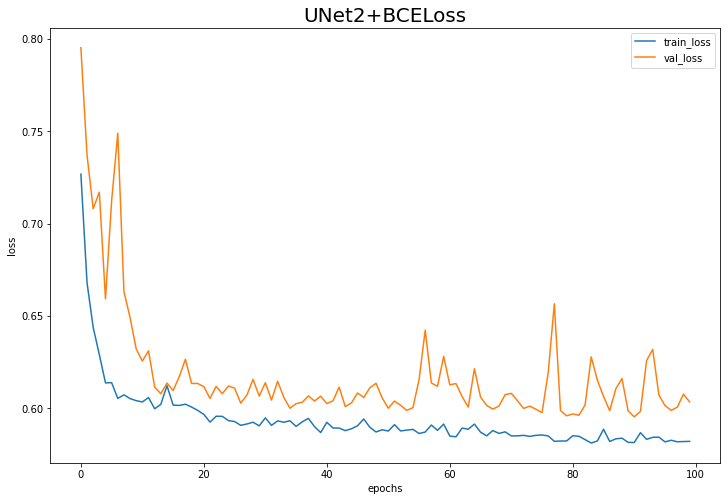

In [ ]:
loss, acc, val_loss, val_acc, ts_loss, ts_acc = zip(*history)
plt.figure(figsize=(12, 8))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.title('UNet2+BCELoss')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

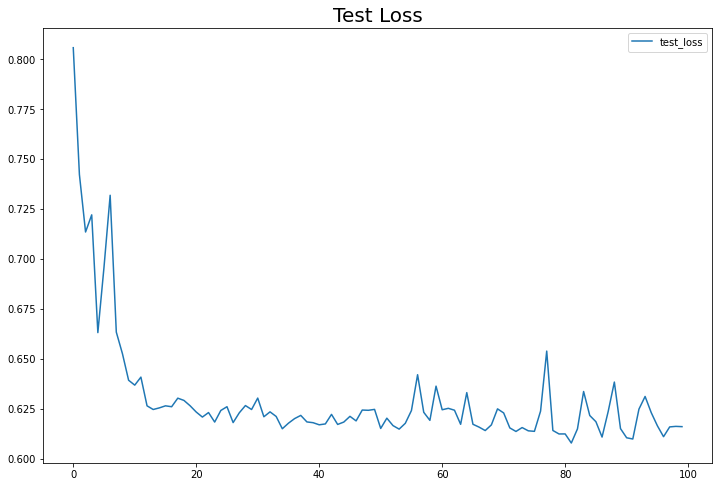

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('Test Loss')
plt.plot(ts_loss, label = 'test_loss')
plt.legend()

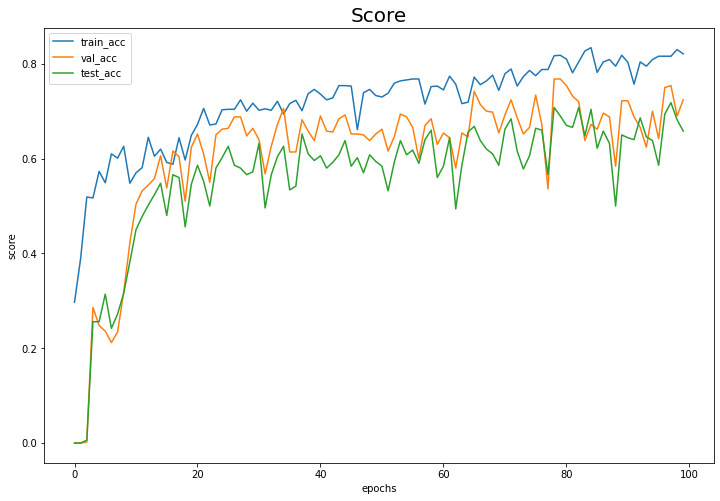

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.plot(ts_acc, label="test_acc")
plt.legend(loc='best')
plt.title('Score')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

##Unet2+FocalLoss

In [ ]:
torch.cuda.empty_cache()
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

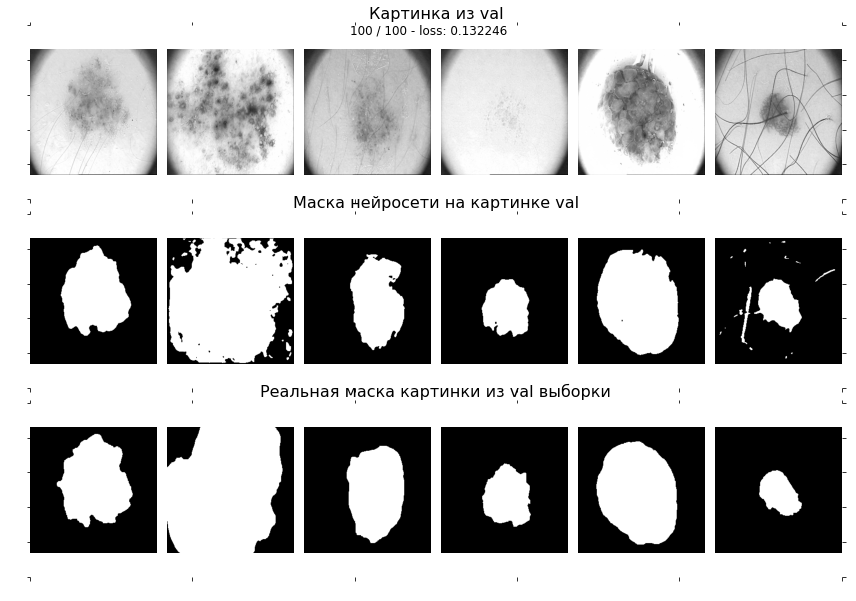

In [ ]:
model = UNet2().to(device)
history = train(model, optim.Adam(model.parameters()), focal_loss, 100, data_tr = data_tr, data_val = data_val, data_ts = data_ts)

In [ ]:
score_model(model, iou_pytorch, data_val)

0.7199999988079071

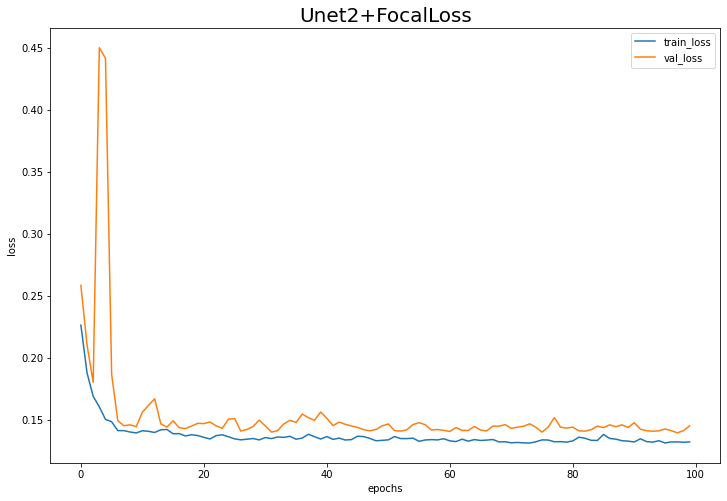

In [ ]:
loss, acc, val_loss, val_acc, ts_loss, ts_acc = zip(*history)
plt.figure(figsize=(12, 8))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.title('Unet2+FocalLoss')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

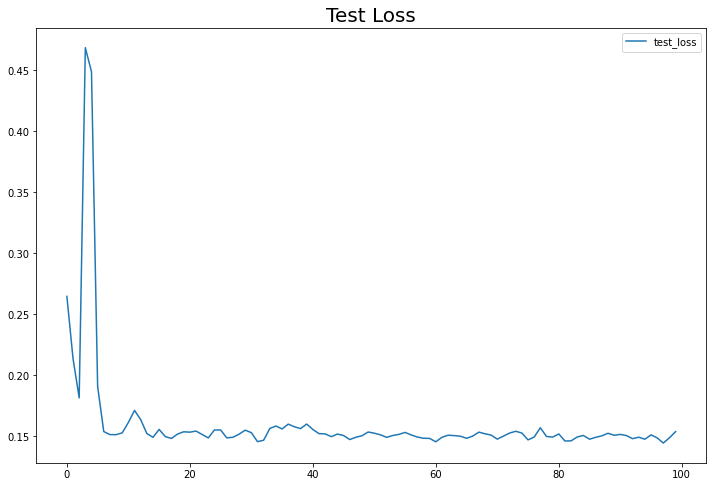

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('Test Loss')
plt.plot(ts_loss, label = 'test_loss')
plt.legend()

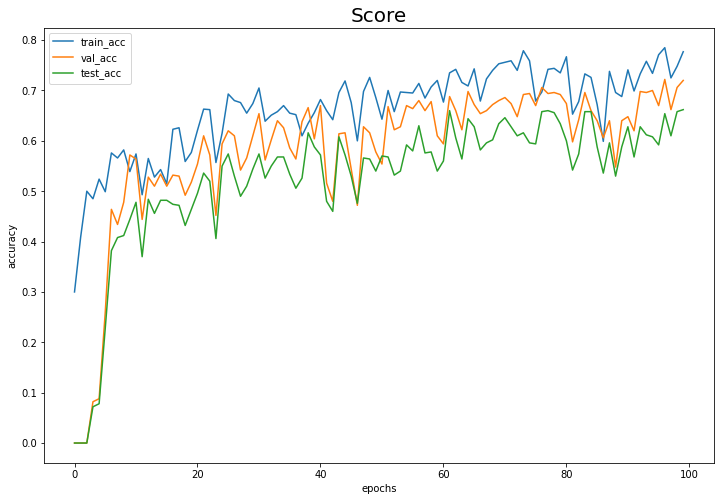

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.plot(ts_acc, label="test_acc")
plt.legend(loc='best')
plt.title('Score')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

##Unet2+DiceLoss

In [ ]:
torch.cuda.empty_cache()
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

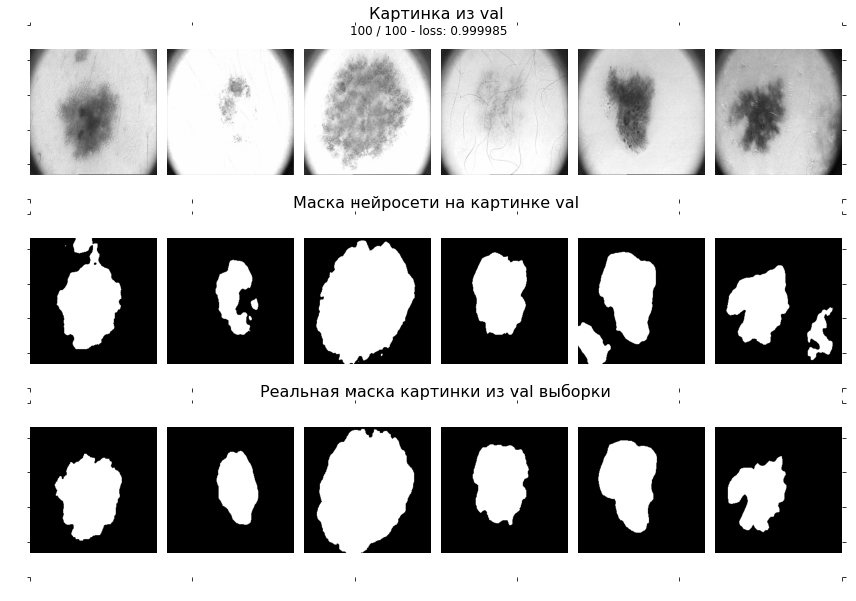

In [ ]:
model = UNet2().to(device)
history = train(model, optim.Adam(model.parameters()), dice_loss, 100, data_tr = data_tr, data_val = data_val, data_ts = data_ts)

In [ ]:
score_model(model, iou_pytorch, data_val)

0.7339999973773956

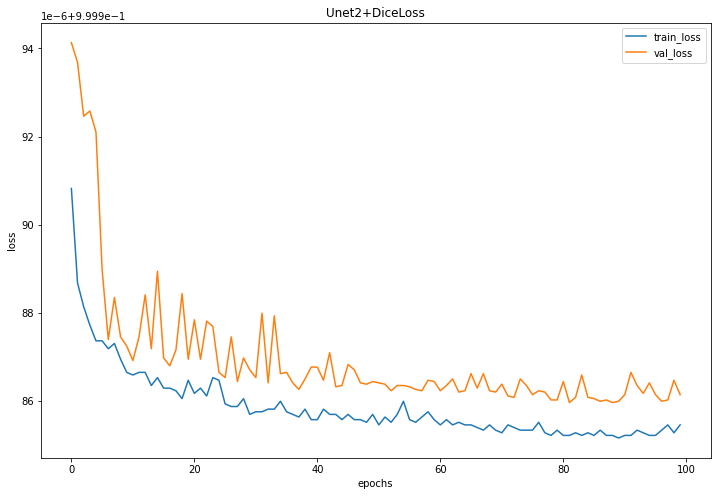

In [ ]:
loss, acc, val_loss, val_acc, ts_loss, ts_acc = zip(*history)
plt.figure(figsize=(12, 8))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.title('Unet2+DiceLoss')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

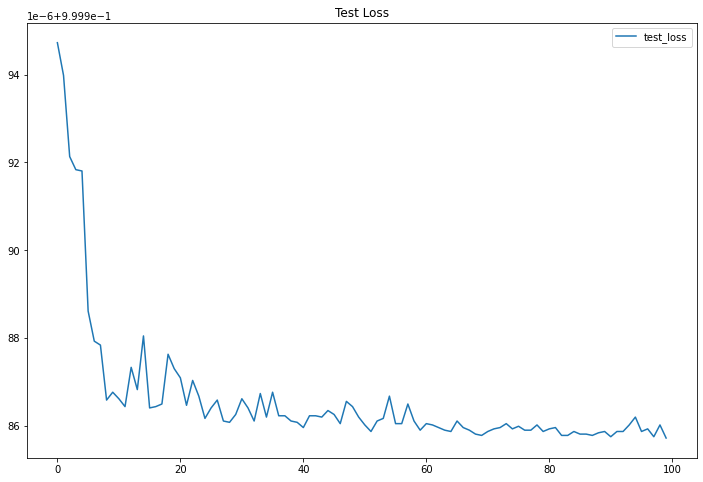

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('Test Loss')
plt.plot(ts_loss, label = 'test_loss')
plt.legend()

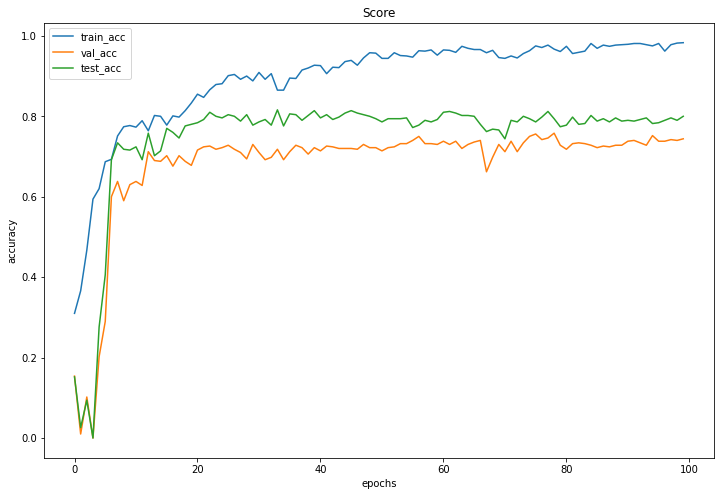

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.plot(ts_acc, label="test_acc")
plt.legend(loc='best')
plt.title('Score')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

##Unet2+SSIM

In [ ]:
torch.cuda.empty_cache()
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

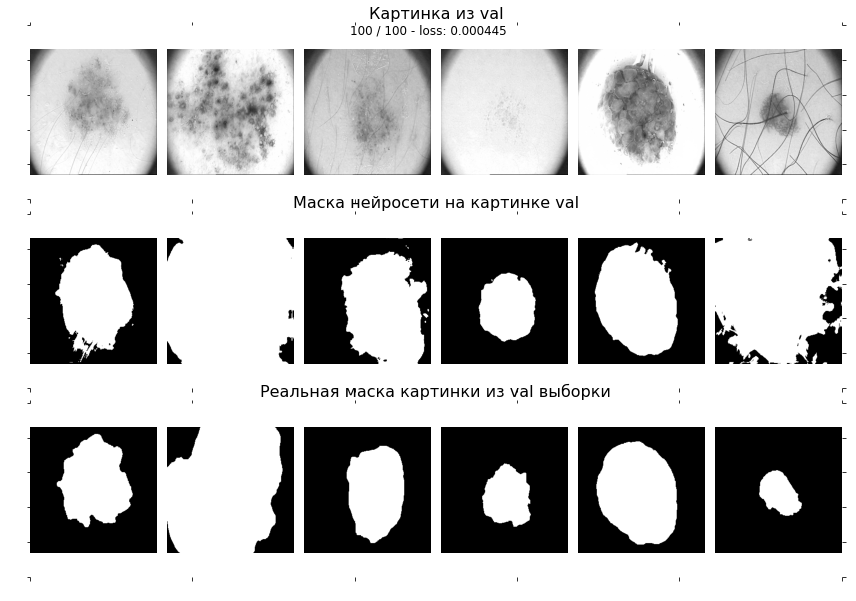

In [ ]:
model = UNet2().to(device)

max_epochs = 100
optimaizer = optim.Adam(model.parameters())
history=train(model, optimaizer, ssim, max_epochs, data_tr = data_tr, data_val = data_val, data_ts = data_ts)

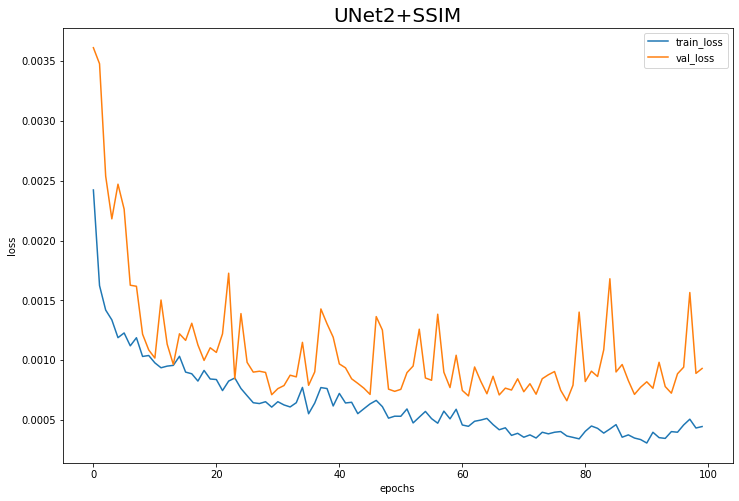

In [ ]:
loss, acc, val_loss, val_acc, ts_loss, ts_acc = zip(*history)
plt.figure(figsize=(12, 8))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.title('UNet2+SSIM')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

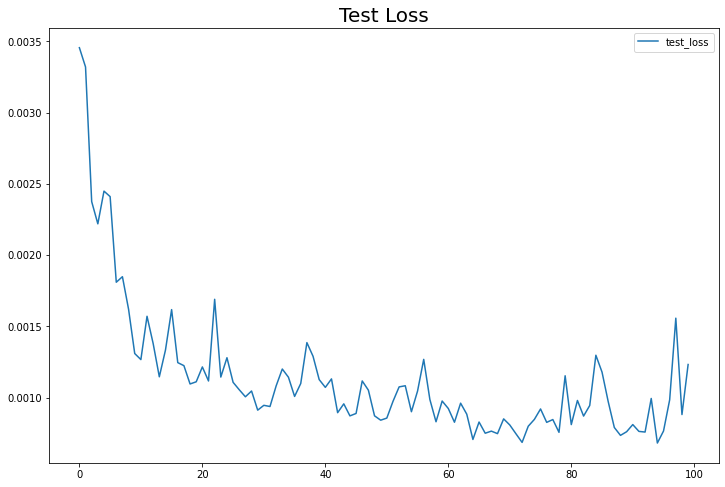

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('Test Loss')
plt.plot(ts_loss, label = 'test_loss')
plt.legend()

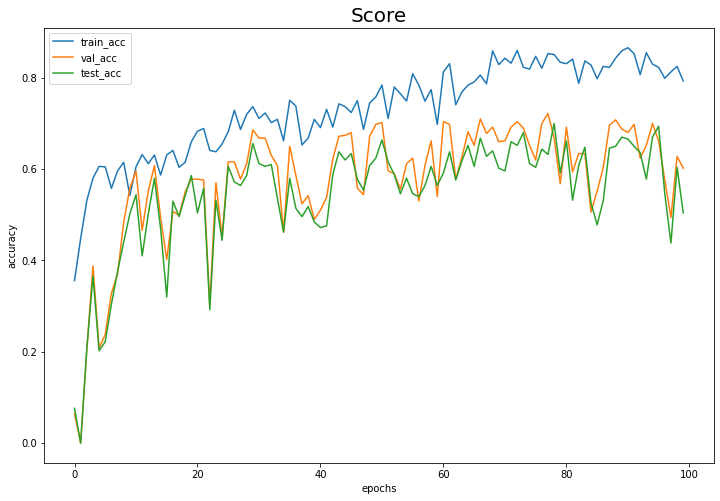

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.plot(ts_acc, label="test_acc")
plt.title('Score')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

In [ ]:
score_model(model, iou_pytorch, data_val)

0.6019999980926514

# Dilated convolutions



Еще один из вариантов делать upsampling и downsampling - использовать для этого *dilated convolutions*:


* Yu, Fisher, and Vladlen Koltun. "[Multi-scale context aggregation by dilated convolutions.](https://arxiv.org/pdf/1511.07122.pdf)" arXiv preprint arXiv:1511.07122 (2015).

попробуйте написать сеть DilatedUNet, которая использует в одной из предыдущих моделей dilated свертки.

In [ ]:
class DilatedUNet(nn.Module):
  def __init__(self):
        super().__init__()
        # encoder (downsampling)
        
        self.x0 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=2, dilation = 2),
                  nn.ReLU(),
                  nn.BatchNorm2d(32),
                  nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
                  nn.ReLU(),
                  nn.BatchNorm2d(32),) 
        self.pool0 = nn.MaxPool2d(2, stride = 2, return_indices=True)# 256 -> 128
        
        self.x1 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=4, dilation = 4),
                  nn.ReLU(),
                  nn.BatchNorm2d(64),
                  nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                  nn.ReLU(),
                  nn.BatchNorm2d(64))
        self.pool1 = nn.MaxPool2d(2, stride = 2,  return_indices=True)# 128 -> 64
        
        self.x2 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=8, dilation = 8),
                  nn.ReLU(),
                  nn.BatchNorm2d(128),
                  nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                  nn.ReLU(),
                  nn.BatchNorm2d(128))
        self.pool2 = nn.MaxPool2d(2, stride = 2,  return_indices=True)# 64 -> 32
        self.x3 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=16, dilation = 16),
                  nn.ReLU(),
                  nn.BatchNorm2d(256),
                  nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                  nn.ReLU(),
                  nn.BatchNorm2d(256))
        self.pool3 = nn.MaxPool2d(2, stride = 2,  return_indices=True)

        # decoder (upsampling)
        self.unpool0 = nn.MaxUnpool2d(2, stride = 2) # 16 -> 32
        self.y0 = nn.Sequential(nn.Conv2d(in_channels=512, out_channels=128, kernel_size=3, padding=8, dilation = 8),
                  nn.ReLU(),
                  nn.BatchNorm2d(128),
                  nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                  nn.ReLU(),
                  nn.BatchNorm2d(128))
        
        self.unpool1 = nn.MaxUnpool2d(2, stride = 2)# 32 -> 64
        self.y1 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=4, dilation = 4),
                  nn.ReLU(),
                  nn.BatchNorm2d(128),
                  nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
                  nn.ReLU(),
                  nn.BatchNorm2d(64))

        self.unpool2 = nn.MaxUnpool2d(2, stride = 2)# 32 -> 64
        self.y2 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=2, dilation = 2),
                  nn.ReLU(),
                  nn.BatchNorm2d(64),
                  nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
                  nn.ReLU(),
                  nn.BatchNorm2d(32))

        self.unpool3 = nn.MaxUnpool2d(2, stride = 2) # 32 -> 64
        self.y_final = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=2, dilation = 2),
                  nn.ReLU(),
                  nn.BatchNorm2d(32),
                  nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
                  nn.ReLU(),
                  nn.BatchNorm2d(32),
                  nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, padding=1))
        
  def forward(self, a):
    a = self.x0(a)
    m = a.clone()
    a, indices0 = self.pool0(a)
    a = self.x1(a)
    l = a.clone()
    a, indices1 = self.pool1(a)
    a = self.x2(a)
    k = a.clone()
    a, indices2 = self.pool2(a)
    a = self.x3(a)
    a_c = a.clone()
    a, indices3 = self.pool3(a)
    a = self.unpool0(a, indices3)
    a = torch.cat((a, a_c),1)
    a = self.y0(a)
    a = self.unpool1(a, indices2)
    a = torch.cat((a, k),1)
    a = self.y1(a)
    a = self.unpool2(a, indices1)
    a = torch.cat((a, l),1)
    a = self.y2(a)
    a = self.unpool2(a, indices0)
    a = torch.cat((a, m),1)
    a=self.y_final(a)
    return a

##DilatedUNet+BCELoss

In [ ]:
torch.cuda.empty_cache()
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

In [ ]:
model = DilatedUNet().to(device)

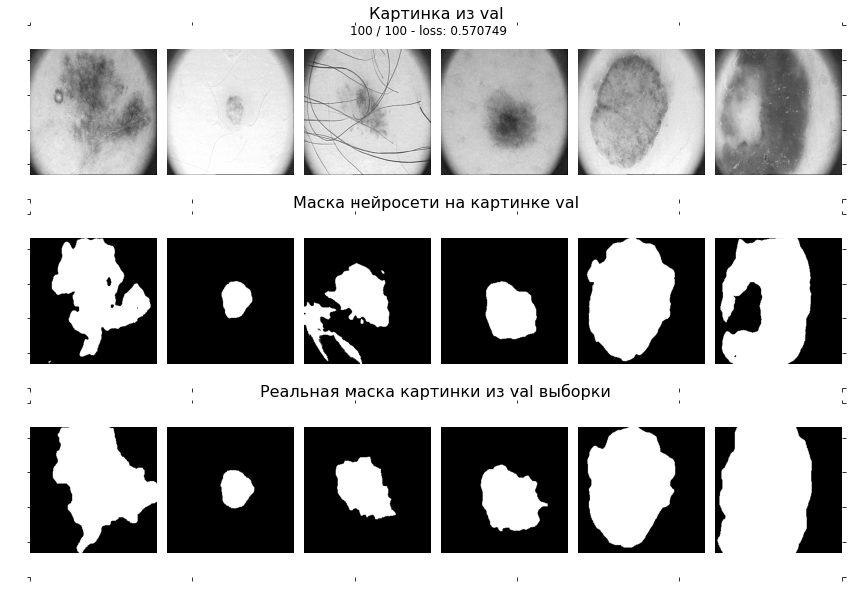

In [ ]:
history=train(model, optim.Adam(model.parameters()), bce_loss, 100, data_tr = data_tr, data_val = data_val, data_ts = data_ts)

In [ ]:
score_model(model, iou_pytorch, data_val)

0.7179999649524689

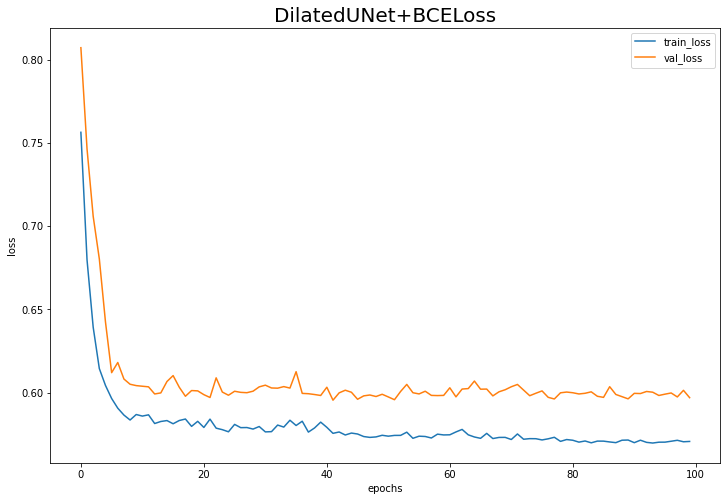

In [ ]:
loss, acc, val_loss, val_acc, ts_loss, ts_acc = zip(*history)
plt.figure(figsize=(12, 8))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.title('DilatedUNet+BCELoss')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

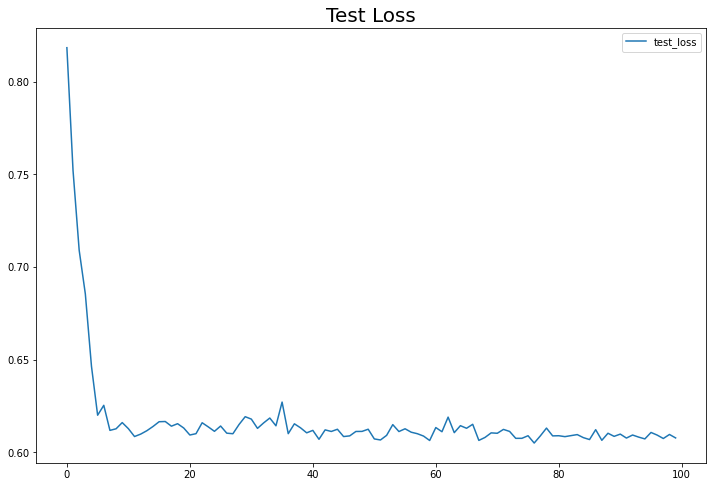

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('Test Loss')
plt.plot(ts_loss, label = 'test_loss')
plt.legend()

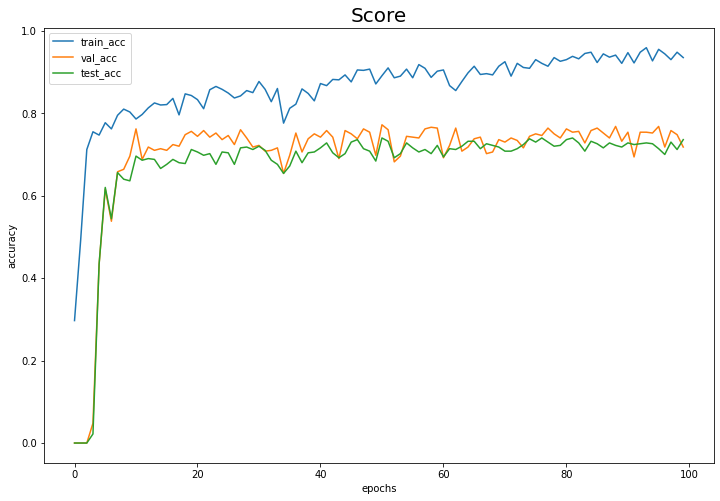

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.plot(ts_acc, label="test_acc")
plt.legend(loc='best')
plt.title('Score')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

##DilatedUNet+FocalLoss

In [ ]:
torch.cuda.empty_cache()
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

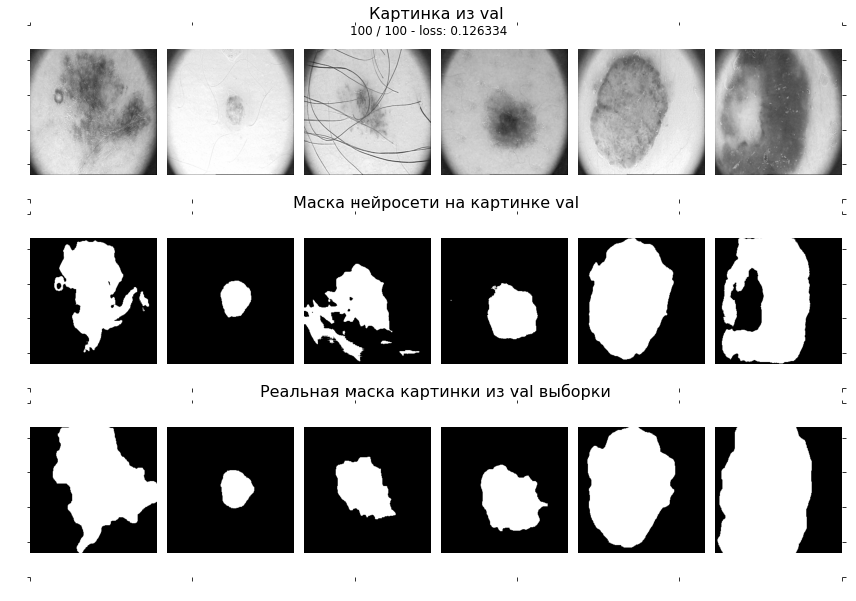

In [ ]:
model = DilatedUNet().to(device)
history=train(model, optim.Adam(model.parameters()), focal_loss, 100,  data_tr = data_tr, data_val = data_val, data_ts = data_ts)

In [ ]:
score_model(model, iou_pytorch, data_val)

0.636000007390976

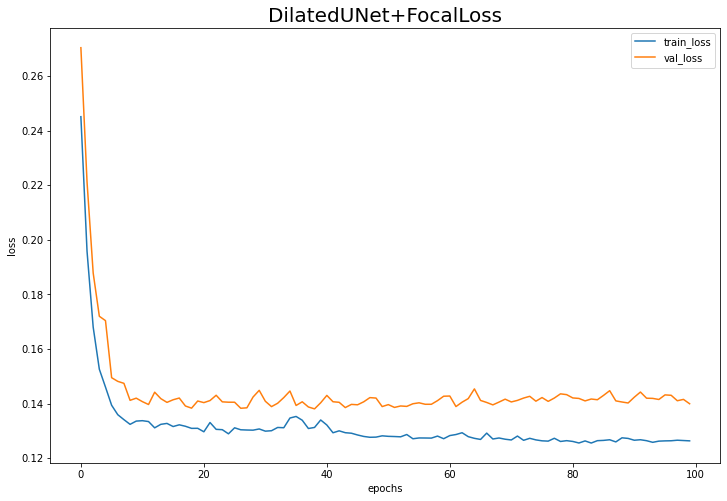

In [ ]:
loss, acc, val_loss, val_acc, ts_loss, ts_acc = zip(*history)
plt.figure(figsize=(12, 8))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.title('DilatedUNet+FocalLoss')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

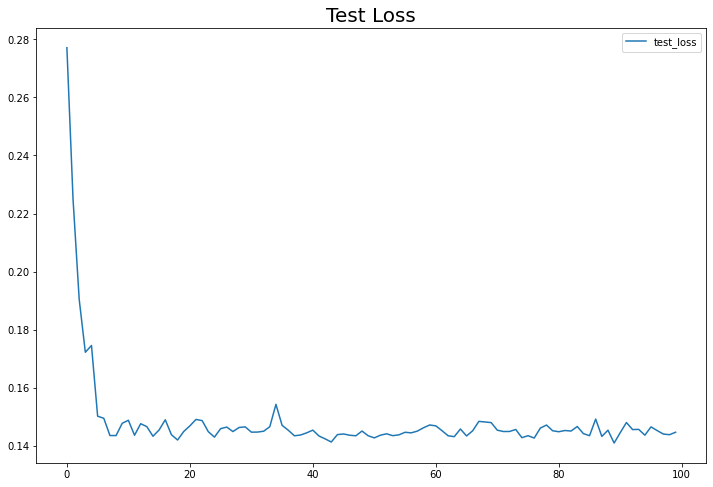

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('Test Loss')
plt.plot(ts_loss, label = 'test_loss')
plt.legend()

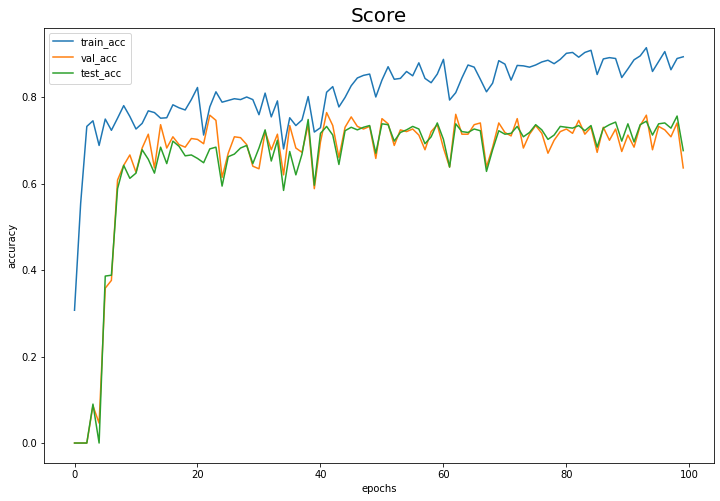

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.plot(ts_acc, label="test_acc")
plt.legend(loc='best')
plt.title('Score')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

##DilatedUnet+DiceLoss

In [ ]:
torch.cuda.empty_cache()
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

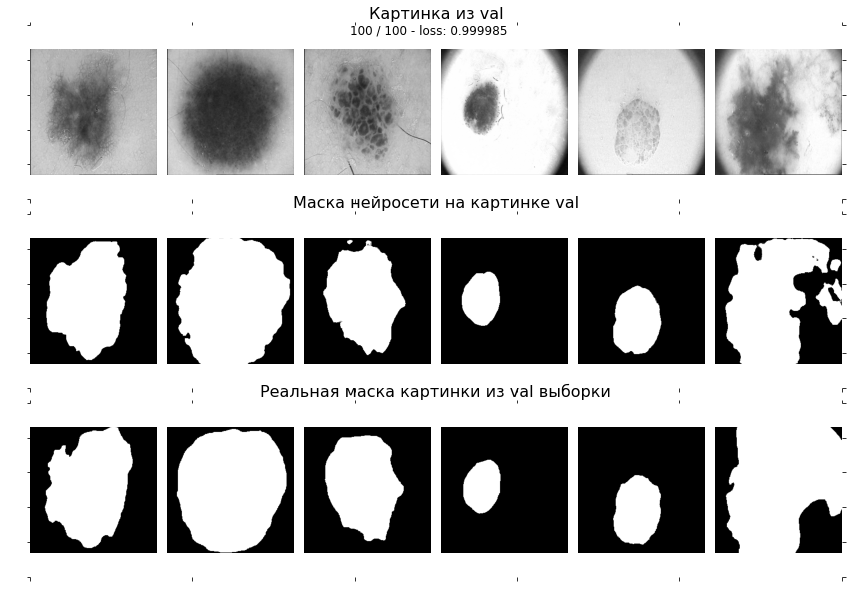

In [ ]:
model = DilatedUNet().to(device)
history=train(model, optim.Adam(model.parameters()), dice_loss, 100, data_tr = data_tr, data_val = data_val, data_ts = data_ts)

In [ ]:
score_model(model, iou_pytorch, data_val)

0.7440000474452972

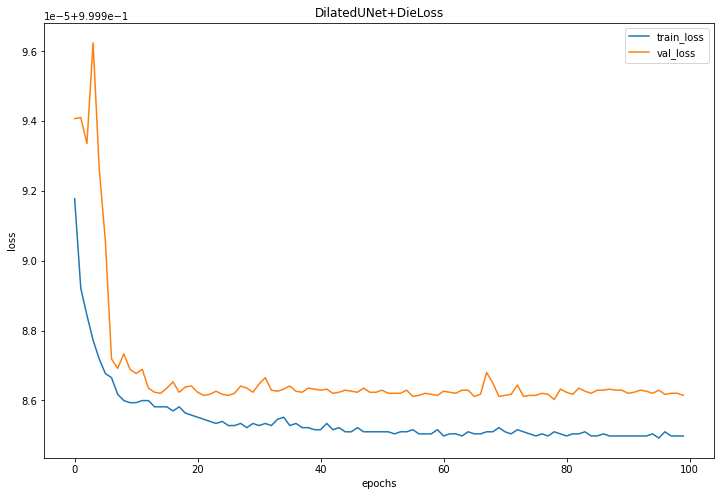

In [ ]:
loss, acc, val_loss, val_acc, ts_loss, ts_acc = zip(*history)
plt.figure(figsize=(12, 8))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.title('DilatedUNet+DieLoss')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

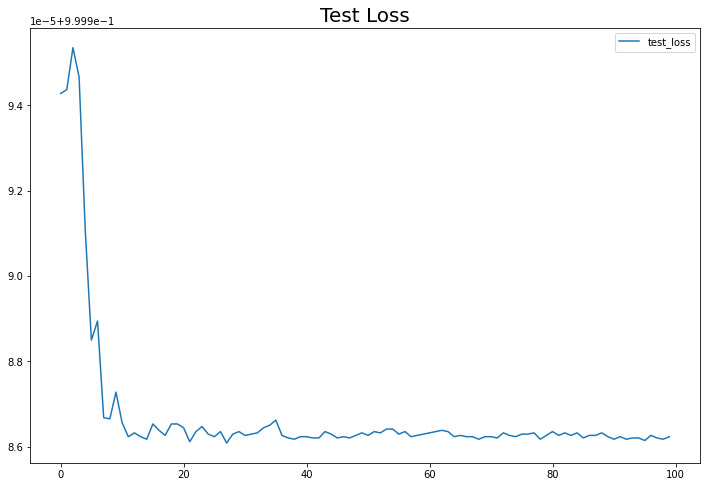

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('Test Loss')
plt.plot(ts_loss, label = 'test_loss')
plt.legend()

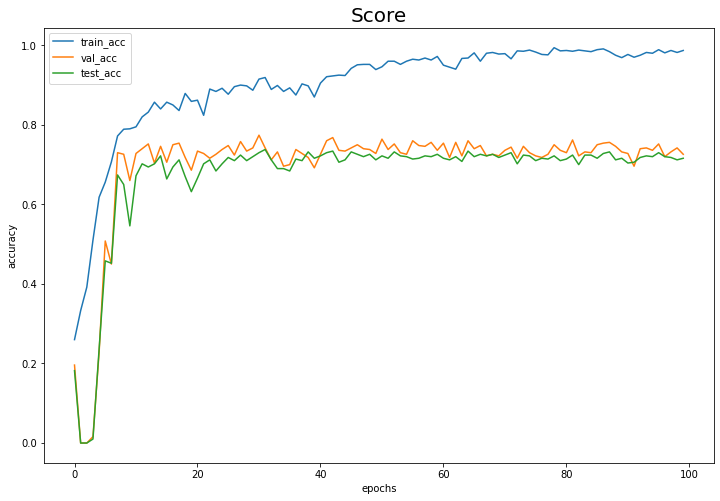

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.plot(ts_acc, label="test_acc")
plt.legend(loc='best')
plt.title('Score')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

##DilatedUNet+SSIM

In [ ]:
torch.cuda.empty_cache()
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

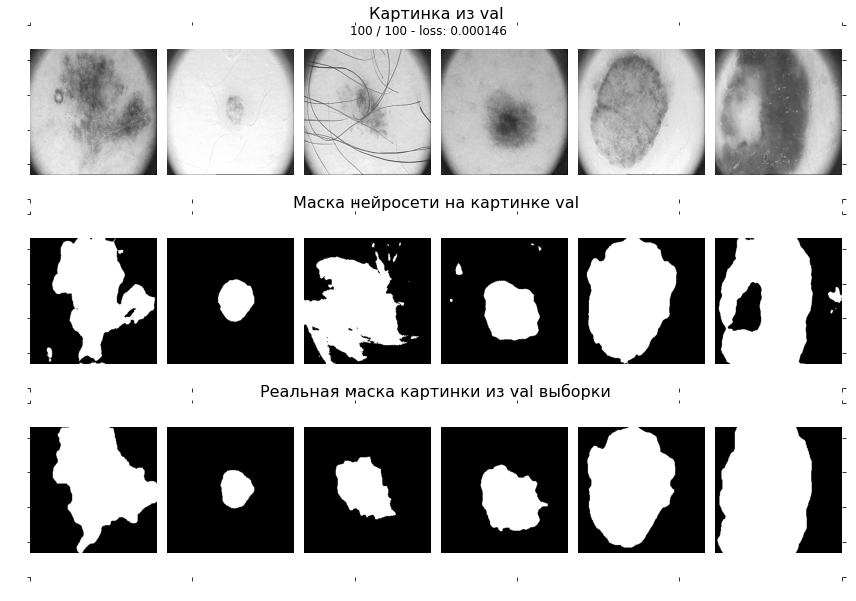

In [ ]:
model = DilatedUNet().to(device)
history=train(model, optim.Adam(model.parameters()), ssim, 100, data_tr = data_tr, data_val = data_val, data_ts = data_ts)

In [ ]:
score_model(model, iou_pytorch, data_val)

0.7320000231266022

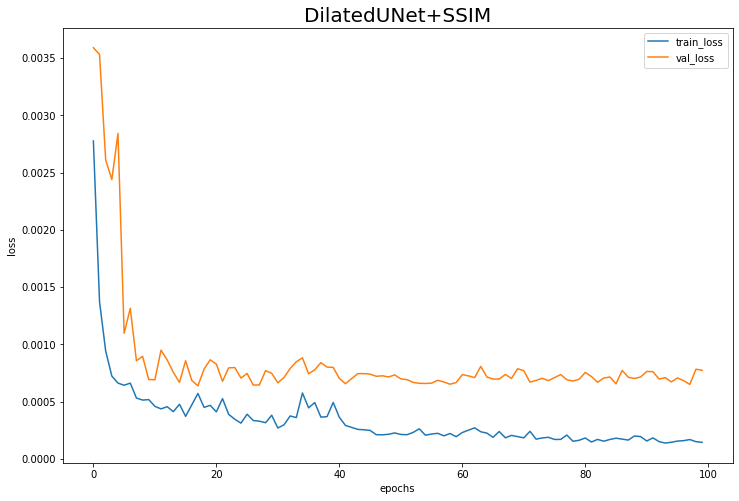

In [ ]:
loss, acc, val_loss, val_acc, ts_loss, ts_acc = zip(*history)
plt.figure(figsize=(12, 8))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.title('DilatedUNet+SSIM')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

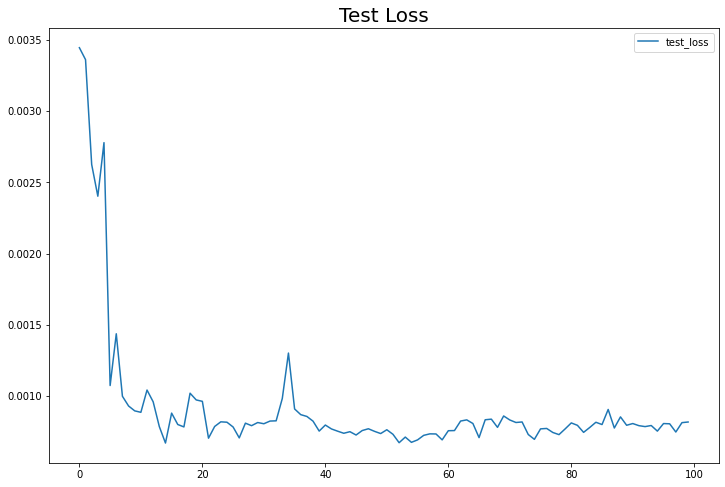

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('Test Loss')
plt.plot(ts_loss, label = 'test_loss')
plt.legend()

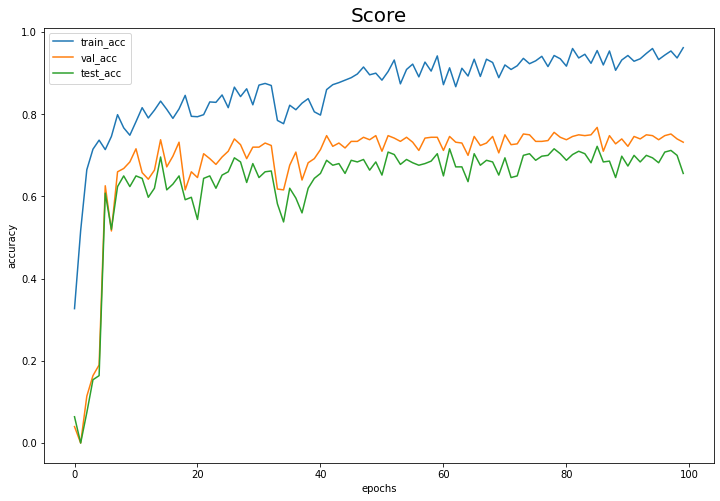

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.plot(ts_acc, label="test_acc")
plt.legend(loc='best')
plt.title('Score')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

# Результат: 
Ну что же, графики лосса и скора на всех выборках представлены в работе,  а сейчас посмотрим на получившиеся результаты в совокупности. Лучший результат показал Unet с DiceLoss - 81%. Худшим оказался Unet2 с SSIM. Стоит отметить, что все сети тестировались в равных условиях - оптимизатор Adam, нет планировщика,  lr = 1e-3. Но к разным сетям и разным функциям потерь нужен разный подход: на некоторых графиках скор похож на расческу - возможно, это значит, что локальный минимум постоянно перескакивается, поэтому шаг нужно уменьшать. Кроме того, Unet и DilatedUnet сходятся быстрее, чем Segnet. Иначе говоря, сравнение не совсем корректно, поскольку не учитывается индивидуальный потенциал сетей.



In [ ]:
dict = {'Net':["Segnet (Upsample)", 'Segnet(Maxunpool)', 'Unet', 'Unet2', 'DilatedUnet'],
        'BCELoss':[0.74, 0.73, 0.76, 0.72, 0.72],
        'DiceLoss':[0.77, 0.67, 0.81, 0.75, 0.73],
        'FocalLoss':[0.75, 0.70, 0.68, 0.72, 0.63],
        'SSIM': [0.72, 0.76, 0.69, 0.6, 0.73]}


In [ ]:
import pandas as pd

Посмотрим на скор

In [ ]:
df = pd.DataFrame(dict)
df

Net  BCELoss  DiceLoss  FocalLoss  SSIM
0  Segnet (Upsample)     0.74      0.77       0.75  0.72
1  Segnet(Maxunpool)     0.73      0.67       0.70  0.76
2               Unet     0.76      0.81       0.68  0.69
3              Unet2     0.72      0.75       0.72  0.60
4        DilatedUnet     0.72      0.73       0.63  0.73